# Atlantic-Eq Mode Study

In [1]:
import matplotlib.pyplot as plt
import numpy as np
from scipy import stats
import matplotlib.ticker as ticker
from netCDF4 import Dataset as ncread
import cartopy.crs as ccrs
import cartopy.feature as cfeature
import random
from tabulate import tabulate
import pandas as pd
import xarray as xr
import warnings
warnings.filterwarnings("ignore", category=RuntimeWarning)
from scipy.interpolate import RegularGridInterpolator
from IPython.display import display, HTML

In [2]:
path = 'E:/TFG/Datos/Importants/'
data1 = path+'HadISST_sst_v1.1_196001_202105.nc'#database_a: HadISST (Hadley Centre Sea Ice and Sea Surface Temperature dataset) de 1960-2021, 1°x1°
data2 = path+'sst.mnmean_v5_196001_202105.nc'   #database_b: ERSST (Extended Reconstructed SST), 2°x2° from NOAA
data3 = path+'noaa.pcp.mon.anom_196001_202105.nc' #datobase1: NOAA (National Oceanic and Atmospheric Administration ), 1.875°x2° 
data4 = path+'pcp.mon.ncep-ncar_196001_202105.nc' #datobase2: NCEP-NCAR, 2.5°x2.5°
#Retrieve data
nc1 = ncread(data1, 'r')  #sst
nc2 = ncread(data2, 'r')  #sst
nc3 = ncread(data3, 'r')  #prec
nc4 = ncread(data4, 'r')  #prec
#vamos a ver las variables que tenemos que llamar de cada archivo
var1 = nc1.variables["sst"]
var2 = nc2.variables["sst"]
var3 = nc3.variables["precip"]
var4 = nc4.variables["prate"]

import numpy as np

def summarize_var(var, nt=None, p=(1, 99)):
    x = var[:] if nt is None else var[:nt]
    if isinstance(x, np.ma.MaskedArray):
        masked = int(np.sum(x.mask))
        x = np.ma.filled(x, np.nan)
    else:
        masked = 0
    x = x.astype(float)
    vals = x[np.isfinite(x)]
    
    return {"units": getattr(var, "units", None),
        "p1": np.percentile(vals, p[0]) if vals.size else np.nan,
        "p99": np.percentile(vals, p[1]) if vals.size else np.nan,
        "min": np.min(vals) if vals.size else np.nan,
        "max": np.max(vals) if vals.size else np.nan,
        "n_total": x.size,
        "masked_count": masked,
        "frac_finite": vals.size / x.size if x.size else np.nan}
    
s1 = summarize_var(var1, nt=732)
s2 = summarize_var(var2, nt=732)
s3 = summarize_var(var3, nt=732)
s4 = summarize_var(var4, nt=732)
# Vamos a crear una tabla para mostrar la naturaleza de los datos:

vars_dict = {"HadISST SST": var1,"ERSST SST": var2,"NOAA PCP": var3,"NCEP-NCAR PCP": var4}
table = []
for name, var in vars_dict.items():
    s = summarize_var(var, nt=732)
    table.append([name,s["units"],(s["p1"], s["p99"]),(s["min"], s["max"]),s["frac_finite"]])
    columns = ["Base de datos","Unidades","p1 / p99","Min / Max","Fracción válida"]

df_table = pd.DataFrame(table, columns=columns)
df_table = df_table.set_index("Base de datos")

df_table["p1 / p99"] = df_table["p1 / p99"].apply(lambda x: f"({x[0]:.2f}, {x[1]:.2f})")

df_table["Min / Max"] = df_table["Min / Max"].apply(lambda x: f"({x[0]:.2f}, {x[1]:.2f})")

df_table["Fracción válida"] = df_table["Fracción válida"].apply(lambda x: f"{x:.2f}")
print(tabulate(df_table, headers="keys", tablefmt="pretty"))



+---------------+----------+-------------------+-------------------+-----------------+
| Base de datos | Unidades |     p1 / p99      |     Min / Max     | Fracción válida |
+---------------+----------+-------------------+-------------------+-----------------+
|  HadISST SST  |    C     | (-1000.00, 29.77) | (-1000.00, 35.21) |      0.67       |
|   ERSST SST   |   degC   |  (-1.80, 29.77)   |  (-1.80, 34.12)   |      0.69       |
|   NOAA PCP    |  mm/day  |   (-2.90, 3.08)   |  (-19.49, 28.87)  |      0.75       |
| NCEP-NCAR PCP | Kg/m^2/s |   (0.00, 11.44)   |  (-0.00, 50.89)   |      1.00       |
+---------------+----------+-------------------+-------------------+-----------------+


<div style="
background-color:#f7f7f7;
border-left:5px solid #444;
padding:14px;
border-radius:4px;
">
Las keys indican que palabra clave esta asociada a cada dato según cada base de datos, vemos que son diferentes en el primer caso por lo que crearemos una funcion que sepa leerlo bien.
</div>


In [3]:
data_files = {"HadISST": data1,"ERSST": data2,"NOAA PCP": data3,"NCEP-NCAR": data4}

# Función para extraer info de los datos, resolución, rango, etc
def ex_info(file_path):
    
    nc = ncread(file_path, "r")  # Abrir archivo NetCDF

     # Verificamos cómo están nombradas las variables de latitud y longitud
    lat_name = next(var for var in nc.variables.keys() if "lat" in var.lower())  #next devuele el primer elemento del iterador 
    lon_name = next(var for var in nc.variables.keys() if "lon" in var.lower())  #util porque no queremos una lista de 1 elemento queremos el string
                                                                                     #lat_name[0] tambien devuelve el primero pero el next te evita
    latitudes = nc.variables[lat_name][:]                                        #crear la lista, es mas eficiente
    longitudes = nc.variables[lon_name][:]

    # Rango de latitud y longitud
    lat_range = (latitudes.min(), latitudes.max())
    lon_range = (longitudes.min(), longitudes.max())

    # Resolución (suponemos que la diferencia entre dos puntos consecutivos es la resolución)
    lat_res = round(abs(latitudes[1] - latitudes[0]),3)
    lon_res = round(abs(longitudes[1] - longitudes[0]),3)

    nc.close()  # Cerrar el archivo para liberar memoria
    return (lat_res, lon_res), lat_range, lon_range

# Crear la tabla con los datos extraídos
table = []
for name, path in data_files.items(): #Este bucle recorre cada par (nombre, ruta) del diccionario.
    info = ex_info(path)  #Pathh en este contexto seria el segundo numero de la dupla es decir data1,data2,etc
    if info:
        table.append([name, *info]) #con el * desempacamos la tupla y la tabla es [HadISST, (1,2),(3,4),(5,6)] y no [HadISST,[(1,2),(3,4),(5,6)]]
        
# Crear DataFrame
columns = ["Base de datos", "Resolución (lat, lon)", "Rango de latitud", "Rango de longitud",]
df_table = pd.DataFrame(table, columns=columns)
df_table = df_table.set_index("Base de datos")


# Hacemos bonita la tabla
df_table["Rango de latitud"] = df_table["Rango de latitud"].apply(lambda x: f"({round(float(x[0]), 2)}°, {round(float(x[1]), 2)}°)")
df_table["Rango de longitud"] = df_table["Rango de longitud"].apply( lambda x: f"({round(float(x[0]), 2)}°, {round(float(x[1]), 2)}°)")
df_table["Resolución (lat, lon)"] = df_table["Resolución (lat, lon)"].apply(lambda x: f"({round(float(x[0]), 3)}°, {round(float(x[1]), 3)}°)")

print(tabulate(df_table, headers="keys", tablefmt="pretty"))




+---------------+-----------------------+-------------------+-------------------+
| Base de datos | Resolución (lat, lon) | Rango de latitud  | Rango de longitud |
+---------------+-----------------------+-------------------+-------------------+
|    HadISST    |     (1.0°, 1.0°)      |  (-89.5°, 89.5°)  | (-179.5°, 179.5°) |
|     ERSST     |     (2.0°, 2.0°)      |  (-88.0°, 88.0°)  |  (0.0°, 358.0°)   |
|   NOAA PCP    |     (2.5°, 2.5°)      | (-88.75°, 88.75°) | (1.25°, 358.75°)  |
|   NCEP-NCAR   |   (1.889°, 1.875°)    | (-88.54°, 88.54°) |  (0.0°, 358.12°)  |
+---------------+-----------------------+-------------------+-------------------+


<div style="
background-color:#f7f7f7;
border-left:5px solid #444;
padding:14px;
border-radius:4px;
">
<b>Tabla de referencia para la selección de rangos</b><br><br>

Esta tabla es necesaria para gestionar de forma coherente cada una de las bases de datos utilizadas.
Actúa como una <b>guía metodológica</b> que permite seleccionar correctamente los distintos conjuntos
de rangos espaciales y temporales empleados en el análisis.

Dado que cada base de datos presenta diferencias en resolución espacial, cobertura y sistema de referencia,
la utilización de esta tabla garantiza que los rangos escogidos sean consistentes y comparables entre productos.
De este modo, se evitan errores derivados de una selección incorrecta de índices.

Las dos bases de datos empleadas presentan rangos espaciales similares en latitud, pero utilizan
convenciones distintas en longitud, lo que debe tenerse en cuenta para una correcta delimitación
de las regiones de estudio.

En latitud, los rangos son:
<ul>
<li><b>ERSST:</b> de −88° a 88°</li>
<li><b>HadISST:</b> de −89.5° a 89.5°</li>
</ul>

En longitud, las diferencias son más relevantes:

<b>HadISST</b> utiliza una convención centrada en el meridiano de Greenwich, con longitudes comprendidas
entre −179.5° y 179.5°, ordenadas de oeste a este:

<div style="font-family: monospace; font-size:13px; width:420px; margin:10px auto;">
<span style="display:block; text-align:center;">−180°&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;0°&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;180°</span>
<span style="display:block; text-align:center;">│────────────────────│────────────────────│</span>
<span style="display:block; text-align:center;">&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;Greenwich</span>
</div

<b>ERSST</b>, en cambio, emplea una convención de 0° a 358°, también ordenada de oeste a este, donde el
meridiano de Greenwich corresponde a 0° y 360° representa de nuevo el mismo meridiano:

<div style="font-family: monospace; font-size:13px; width:420px; margin:10px auto;">
<span style="display:block; text-align:right;">0°&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;180°&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;360° (= 0°)</span>
<span style="display:block; text-align:center;">│────────────────────│─────────────────────│</span>
<span style="display:block; text-align:right;">Greenwich&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;Océano&nbsp;Pacífico&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;Greenwich</span>
</div>

En el caso de <b>HadISST</b>, la interpretación de la longitud resulta directa.
Sin embargo, en <b>ERSST</b> es fundamental tener en cuenta que el valor 0° corresponde al meridiano
de Greenwich. Tener en cuenta esto es importante para la definición de áreas geográficas
y, por tanto, en los cálculos espaciales posteriores.

</div>


</div



-0.04 5.2519994


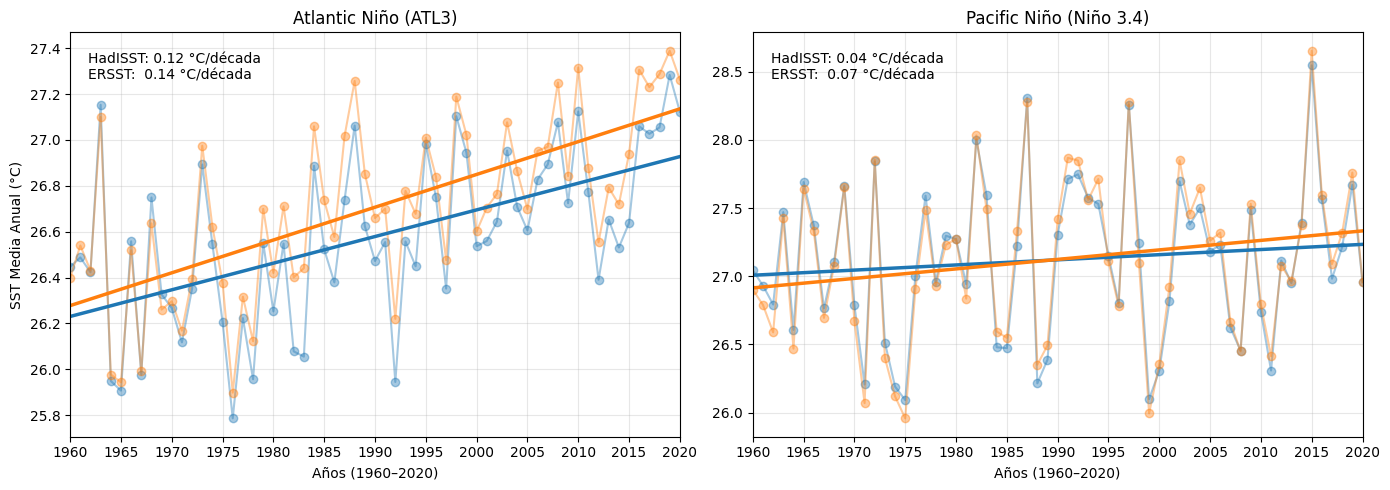

In [4]:
#Entendemos nuestros datos:
sst_a = nc1.variables['sst'][:732] #HadISST: R=1°x1°,
sst_b = nc2.variables['sst'][:732] #ERSSTD:  R=2°x2°   
pcp = nc3.variables['precip'][:732] #NOAA PCP:  R=2.5°x2.5°
pcp2 = nc4.variables['prate'][:732] #NCEP-NCAR:  R=1.889°x1.875°

print (pcp[59,50,30],pcp2[50,50,30])

def lat_lon(file_path): #funcion para retornar long y lat en funcion de la data
    nc = ncread(file_path, "r")
    lat_name = next(var for var in nc.variables.keys() if "lat" in var.lower()) #busca el nombre asociado las coordenadas
    lon_name = next(var for var in nc.variables.keys() if "lon" in var.lower()) #suponemos que contiene lat/lon
    longitudes = nc.variables[lon_name][:]
    latitudes = nc.variables[lat_name][:]                                        
    nc.close()
    return longitudes, latitudes
    
lon_a, lat_a  = lat_lon(data1)
lon_b, lat_b  = lat_lon(data2)
lon_pcp, lat_pcp  = lat_lon(data3)
lon_pcp2, lat_pcp2  = lat_lon(data4)

nt = len(sst_a[:,0,0])
nyr = int(nt/12) 
ny_a = len(lat_a)
ni_a = len(lon_a)   # al haber diferentes resoluciones el numeros de lat y longitud varia asi que mejor mirar todas
ny_b = len(lat_b) 
ni_b = len(lon_b)
ny_pcp = len(lat_pcp)
ni_pcp = len(lon_pcp)
ny_pcp2 = len(lat_pcp2)
ni_pcp2 = len(lon_pcp2)

sst_a = np.where(sst_a <= -1.79, np.nan, sst_a)  # SST oceánica no baja de -1.8°C
sst_a = np.where(sst_a > 40, np.nan, sst_a)    # SST oceánica no sube de ~35°C
sst_b = np.where(sst_b <= -1.79, np.nan, sst_b)  # SST oceánica no baja de -1.8°C
sst_b = np.where(sst_b > 40, np.nan, sst_b)    # SST oceánica no sube de ~35°C

# Calcular medias anuales (732 meses = 61 años)
sst_a_annual = sst_a.reshape(61, 12, *sst_a.shape[1:]).mean(axis=1)
sst_b_annual = sst_b.reshape(61, 12, *sst_b.shape[1:]).mean(axis=1)

Temp_ATL3_a = []
Temp_ATL3_b = []
Temp_Niño_a = []
Temp_Niño_b = []

for i in range(61):
    matriuATL3_a = sst_a_annual[i, 86:94, 160:180]      # HadISST
    Temp_ATL3_a.append(np.mean(matriuATL3_a))

    matriuATL3_b = sst_b_annual[i, 42:47, 170:180]      # ERSST
    Temp_ATL3_b.append(np.mean(matriuATL3_b))

    matriuNiño_a = sst_a_annual[i, 84:96, 10:60]      # HadISST
    Temp_Niño_a.append(np.mean(matriuNiño_a))

    matriuNiño_b = sst_b_annual[i, 41:47, 95:120]      # ERSST
    Temp_Niño_b.append(np.mean(matriuNiño_b))



    
Temp_ATL3_a = np.array(Temp_ATL3_a)
Temp_ATL3_b = np.array(Temp_ATL3_b)
Temp_Niño_a = np.array(Temp_Niño_a)
Temp_Niño_b = np.array(Temp_Niño_b)

# Tendencias lineales
years=(np.arange(1960, 2021, 1))
# ATL3
coef_ATL3_a = np.polyfit(years, Temp_ATL3_a, 1)
coef_ATL3_b = np.polyfit(years, Temp_ATL3_b, 1)

trend_ATL3_a = np.polyval(coef_ATL3_a, years)
trend_ATL3_b = np.polyval(coef_ATL3_b, years)

slope_ATL3_a_dec = coef_ATL3_a[0] * 10
slope_ATL3_b_dec = coef_ATL3_b[0] * 10

# Niño 3.4
coef_Niño_a = np.polyfit(years, Temp_Niño_a, 1)
coef_Niño_b = np.polyfit(years, Temp_Niño_b, 1)

trend_Niño_a = np.polyval(coef_Niño_a, years)
trend_Niño_b = np.polyval(coef_Niño_b, years)

slope_Niño_a_dec = coef_Niño_a[0] * 10
slope_Niño_b_dec = coef_Niño_b[0] * 10

# Figura con dos paneles


fig, axs = plt.subplots(1, 2, figsize=(14, 5), sharex=True)

# ATL3
axs[0].plot(years, Temp_ATL3_a, 'o-', color='C0', alpha=0.4, label='HadISST (datos)')
axs[0].plot(years, Temp_ATL3_b, 'o-', color='C1', alpha=0.4, label='ERSST (datos)')
axs[0].plot(years, trend_ATL3_a, color='C0', lw=2.5, label='HadISST – Tendencia')
axs[0].plot(years, trend_ATL3_b, color='C1', lw=2.5, label='ERSST – Tendencia')

axs[0].set_title('Atlantic Niño (ATL3)')
axs[0].set_ylabel('SST Media Anual (°C)')
axs[0].set_xlim(1960, 2020)
axs[0].grid(True, alpha=0.3)

axs[0].text(
    0.03, 0.95,
    f"HadISST: {slope_ATL3_a_dec:.2f} °C/década\n"
    f"ERSST:  {slope_ATL3_b_dec:.2f} °C/década",
    transform=axs[0].transAxes,
    fontsize=10,
    verticalalignment='top'
)

# Niño 3.4
axs[1].plot(years, Temp_Niño_a, 'o-', color='C0', alpha=0.4, label='HadISST (datos)')
axs[1].plot(years, Temp_Niño_b, 'o-', color='C1', alpha=0.4, label='ERSST (datos)')
axs[1].plot(years, trend_Niño_a, color='C0', lw=2.5, label='HadISST – Tendencia')
axs[1].plot(years, trend_Niño_b, color='C1', lw=2.5, label='ERSST – Tendencia')

axs[1].set_title('Pacific Niño (Niño 3.4)')
axs[1].set_xlim(1960, 2020)
axs[1].grid(True, alpha=0.3)

axs[1].text(
    0.03, 0.95,
    f"HadISST: {slope_Niño_a_dec:.2f} °C/década\n"
    f"ERSST:  {slope_Niño_b_dec:.2f} °C/década",
    transform=axs[1].transAxes,
    fontsize=10,
    verticalalignment='top'
)
# Ejes comunes
for ax in axs:
    ax.set_xlabel('Años (1960–2020)')
    ax.set_xticks(np.arange(1960, 2021, 5))

plt.tight_layout()
plt.show()





<div style="
background-color:#f7f7f7;
border-left:5px solid #444;
padding:14px;
border-radius:4px;
">

<b>Temperatura media anual y metodología de cálculo</b><br><br>
Se muestran dos gráficas correspondientes a la temperatura media anual en las regiones del 
<b>Atlantic Niño (ATL3)</b> y del <b>Pacific Niño (Niño 3.4)</b>.
En ambas regiones se observa una <b>clara tendencia positiva</b> de la temperatura a lo largo del periodo de estudio.
Dado que esta señal está asociada al calentamiento global, es necesario aplicar un 
<b>detrend</b> previo al cálculo de las anomalías climáticas.
Además, puesto que la magnitud de la tendencia difiere entre regiones, este detrend debe aplicarse
<b>punto a punto</b> en cada celda espacial.



Las dos bases de datos analizadas,
<span style="color:#ADD8E6;"><b>HadISST</b></span> y
<span style="color:#FFA500;"><b>ERSST</b></span>,
presentan resultados coherentes con lo esperado.
ERSST muestra sistemáticamente valores ligeramente más elevados, aunque dentro de un margen razonable.
Estas diferencias se explican por el distinto sistema de observación, la frecuencia temporal,
la resolución espacial y las metodologías de reconstrucción empleadas en cada producto,
lo que introduce un pequeño <i>offset</i> entre ambas bases de datos.


Se descartan los valores de temperatura superiores a <b>35&nbsp;°C</b> para evitar la contaminación por puntos de tierra,
así como los valores inferiores a <b>−1.79&nbsp;°C</b>.
Este último umbral es especialmente relevante en ERSST, donde la región cubierta por hielo en el Ártico
presenta valores cercanos a −1.8&nbsp;°C que distorsionan la media y los cálculos posteriores.

Para el cálculo de la temperatura media en cada región se ha utilizado inicialmente
la media directa de la matriz de datos.
No obstante, esta aproximación no es estrictamente correcta, ya que el área representada por cada celda
depende de la latitud.
La forma físicamente correcta de calcular la media espacial es ponderar cada celda
por el coseno de la latitud, de acuerdo con la expresión:
</div>

$$
\overline{T}
=
\frac{\sum_{\varphi,\lambda} T(\varphi,\lambda)\,\cos(\varphi)}
     {\sum_{\varphi,\lambda} \cos(\varphi)}
$$

<div style="
background-color:#f7f7f7;
border-left:5px solid #444;
padding:14px;
border-radius:4px;
">
Esta ponderación es necesaria porque la Tierra es una esfera y el área de las celdas disminuye con la latitud.
Para latitudes bajas, como las consideradas en este estudio, el error cometido al no aplicar esta corrección
es muy reducido (del orden del <b>0.5&nbsp;%</b>), por lo que la aproximación resulta aceptable.

De forma análoga, en el cálculo inicial se han utilizado los índices directos de la malla
en lugar de interpolar exactamente los límites geográficos de cada región.
Esto puede introducir pequeñas discrepancias, pero dado que las áreas analizadas son amplias
y se encuentran próximas al ecuador, el impacto debido al cambio de latitud (coger valores de latitud diferentes porque estan en nuestra malla) es mínimo. Además no estudiar las zonas exactas por decimas de grados no es un problema ya los gradientes meridionales cerca del ecuador son suaves.

En la siguiente celda se repite el cálculo sin ninguna de estas aproximaciones
(interpolación espacial y media ponderada por coseno de la latitud)
con el objetivo de verificar cuantitativamente que las diferencias introducidas son despreciables.
</div>

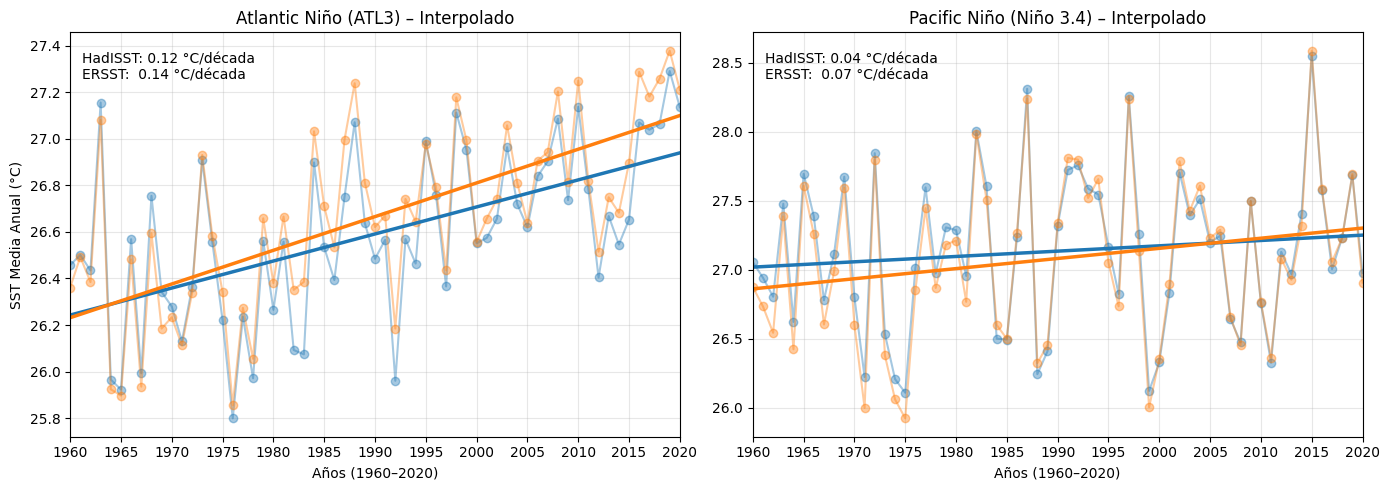

In [5]:

def lon_to_180(lon):
    lon = np.array(lon, dtype=float)
    return ((lon + 180) % 360) - 180

def _ensure_increasing(lat, lon, field2d):
    lat = np.array(lat); lon = np.array(lon)
    if lat[0] > lat[-1]:
        lat = lat[::-1]
        field2d = field2d[::-1, :]
    lon_sort_idx = np.argsort(lon)
    lon = lon[lon_sort_idx]
    field2d = field2d[:, lon_sort_idx]
    return lat, lon, field2d

def interp2d_to_target(lat_src, lon_src, field2d, lat_t, lon_t):
    lat_src, lon_src, field2d = _ensure_increasing(lat_src, lon_src, field2d)
    interp = RegularGridInterpolator((lat_src, lon_src), field2d, method="linear",
                                    bounds_error=False, fill_value=np.nan)
    LonT, LatT = np.meshgrid(lon_t, lat_t)
    pts = np.column_stack([LatT.ravel(), LonT.ravel()])
    return interp(pts).reshape(len(lat_t), len(lon_t))

def area_weighted_mean(field2d, lat_t):
    w = np.cos(np.deg2rad(lat_t))[:, None]
    m = np.isfinite(field2d)
    return np.nan if not np.any(m) else np.nansum(field2d * w) / np.nansum(w * m)

# --- Longitudes coherentes ---
lon_a_180 = lon_to_180(lon_a)
lon_b_180 = lon_to_180(lon_b)

years = np.arange(1960, 2021, 1)
ddeg = 0.25

def series_box(lat_min, lat_max, lon_min, lon_max):
    lat_t = np.arange(lat_min, lat_max + 1e-9, ddeg)
    lon_t = np.arange(lon_min, lon_max + 1e-9, ddeg)
    A = np.empty(61); B = np.empty(61)
    for i in range(61):
        fld_a = interp2d_to_target(lat_a, lon_a_180, sst_a_annual[i, :, :], lat_t, lon_t)
        fld_b = interp2d_to_target(lat_b, lon_b_180, sst_b_annual[i, :, :], lat_t, lon_t)
        A[i] = area_weighted_mean(fld_a, lat_t)
        B[i] = area_weighted_mean(fld_b, lat_t)
    return A, B

def trend(y):
    c = np.polyfit(years, y, 1)
    return np.polyval(c, years), c[0] * 10

# ATL3: 4S–4N, 20W–0  (en -180..180)
Temp_ATL3_a_intr, Temp_ATL3_b_intr = series_box(-4, 4, -20, 0)

# Niño 3.4 (tus coordenadas): 6S–6N, 170W–120W  -> -170 .. -120
Temp_Niño_a_intr, Temp_Niño_b_intr = series_box(-6, 6, -170, -120)

trend_ATL3_a, slope_ATL3_a_dec = trend(Temp_ATL3_a_intr)
trend_ATL3_b, slope_ATL3_b_dec = trend(Temp_ATL3_b_intr)
trend_Niño_a, slope_Niño_a_dec = trend(Temp_Niño_a_intr)
trend_Niño_b, slope_Niño_b_dec = trend(Temp_Niño_b_intr)

fig, axs = plt.subplots(1, 2, figsize=(14, 5), sharex=True)

# --- ATL3 ---
axs[0].plot(years, Temp_ATL3_a_intr, 'o-', label='HadISST interp (datos)', color='C0', alpha=0.4)
axs[0].plot(years, Temp_ATL3_b_intr, 'o-', label='ERSST interp (datos)', color='C1', alpha=0.4)
axs[0].plot(years, trend_ATL3_a, label='HadISST interp – Tendencia', color='C0', lw=2.5)
axs[0].plot(years, trend_ATL3_b, label='ERSST interp – Tendencia', color='C1', lw=2.5)
axs[0].set_title('Atlantic Niño (ATL3) – Interpolado')
axs[0].set_ylabel('SST Media Anual (°C)')
axs[0].grid(True, alpha=0.3)
axs[0].text(0.02, 0.95,
            f"HadISST: {slope_ATL3_a_dec:.2f} °C/década\nERSST:  {slope_ATL3_b_dec:.2f} °C/década",
            transform=axs[0].transAxes, fontsize=10, va="top")

# --- Niño 3.4 ---
axs[1].plot(years, Temp_Niño_a_intr, 'o-', label='HadISST interp (datos)', color='C0', alpha=0.4)
axs[1].plot(years, Temp_Niño_b_intr, 'o-', label='ERSST interp (datos)', color='C1', alpha=0.4)
axs[1].plot(years, trend_Niño_a, label='HadISST interp – Tendencia', color='C0', lw=2.5)
axs[1].plot(years, trend_Niño_b, label='ERSST interp – Tendencia', color='C1', lw=2.5)
axs[1].set_title('Pacific Niño (Niño 3.4) – Interpolado')
axs[1].grid(True, alpha=0.3)
axs[1].text(0.02, 0.95,
            f"HadISST: {slope_Niño_a_dec:.2f} °C/década\nERSST:  {slope_Niño_b_dec:.2f} °C/década",
            transform=axs[1].transAxes, fontsize=10, va="top")

for ax in axs:
    ax.set_xlabel('Años (1960–2020)')
    ax.set_xlim(1960, 2020)
    ax.set_xticks(np.arange(1960, 2021, 5))

plt.tight_layout()
plt.show()


<div style="
background-color:#f7f7f7;
border-left:5px solid #444;
padding:14px;
border-radius:4px;
">
Como ya habiamos previsto la interpolación es inncesaria para nuestras zonas de estudio, como el area efectiva depende del coseno de la latitud y en nuestras zonas tenemos unas latitudes del orden de 5° como máximo este coseno da 0.996, se pierde menos de un 0.4% en el peor de los casos. Las tendencias dan igual y solo vemos ligeras diferencias en los maximos pero menores a 0.1°C.
</div>

In [6]:
# redefinimos 
sst_a = nc1.variables['sst'][:732] #HadISST: R=1°x1°
sst_b = nc2.variables['sst'][:732] #ERSST:  R=2°x2°   

def to_float_nan(a):
    """Convierte Variable/MaskedArray a ndarray float con NaNs donde haya máscara."""
    if np.ma.isMaskedArray(a):
        return np.ma.filled(a, np.nan).astype(float)
    return np.array(a, dtype=float)

def calc_monthly_anoms(fen, detrend=True):
    """
    fen: (time, lat, lon) mensual
    return: anoms (year, month, lat, lon)
    """
    arr = to_float_nan(fen)

    # Si viniera 4D (time, level, lat, lon), toma level 0
    if arr.ndim == 4:
        arr = arr[:, 0, :, :]
    if arr.ndim != 3:
        raise ValueError(f"Se esperaba (time, lat, lon), pero llegó {arr.shape}")

    nt, ny, nx = arr.shape
    nyr = nt // 12
    nt_use = nyr * 12
    dat = arr[:nt_use].copy()

    # Detrend (estable): ajusta con NaNs rellenados, resta solo donde hay dato
    if detrend:
        x = np.arange(nt_use)
        X = np.column_stack([x, np.ones(nt_use)])          # (nt, 2)
        Y = dat.reshape(nt_use, -1)                        # (nt, ngrid)
        Yf = np.nan_to_num(Y, nan=0.0)                     # para que lstsq no reviente

        coeffs = np.linalg.lstsq(X, Yf, rcond=None)[0]     # (2, ngrid)
        trend = (X @ coeffs).reshape(dat.shape)            # (nt, ny, nx)

        mask = np.isfinite(dat)
        dat[mask] = dat[mask] - trend[mask]

    # Climatología mensual y anomalías
    dat4 = dat.reshape(nyr, 12, ny, nx)                    # (year, month, lat, lon)
    clim = np.nanmean(dat4, axis=0)                        # (month, lat, lon)
    anoms = dat4 - clim[None, :, :, :]                     # (year, month, lat, lon)
    return anoms
            
#calculem les anomalies dels 4 casos, fem reshape

anoms_a0 = calc_monthly_anoms(sst_a, detrend=True)
anoms_b = calc_monthly_anoms(sst_b, detrend=True)
#en la primera tabla y leyendo la data nos damos cuenta que pcp ya viene en forma de anomalias pero hay que modificar us forma (messes,lat,lon)->(year, month, lat, lon)
mes, lat, lon = pcp.shape
yr = mes // 12
anoms_pcp = pcp.reshape(yr,12,lat,lon)
anoms_pcp2 = calc_monthly_anoms(pcp2, detrend=True) #recordar que pcp eran anomalias solo necesitamos calcular las de pcp2

def plot_anom_summary(ax, lon, lat, anoms, title, cb_label):
    # Campo diagnóstico: máximo absoluto
    field = np.nanmax(np.abs(anoms), axis=(0, 1))  # (lat, lon)

    ax.add_feature(cfeature.COASTLINE)
    ax.add_feature(cfeature.LAND, facecolor='lightgray')
    ax.gridlines(draw_labels=True)

    levels = np.linspace(0, 10, 11)

    fill = ax.contourf(
        lon, lat, field,
        levels=levels,
        transform=ccrs.PlateCarree(),
        cmap='YlOrRd',
        extend='max'
    )

    ax.set_title(title, fontsize=12)

    cb = plt.colorbar(
        fill,
        ax=ax,
        orientation='horizontal',
        pad=0.05,
        aspect=40
    )
    cb.set_label(cb_label, fontsize=12)

    # --- mini leyenda min / max ---
    vmin = np.nanmin(field)
    vmax = np.nanmax(field)

    txt = f"min = {vmin:.2f}\nmax = {vmax:.2f}"

    ax.text(
        0.02, 0.02, txt,
        transform=ax.transAxes,
        fontsize=9,
        verticalalignment='bottom',
        horizontalalignment='left',
        bbox=dict(
            facecolor='white',
            edgecolor='none',
            alpha=0.75
        )
    )

    return fill



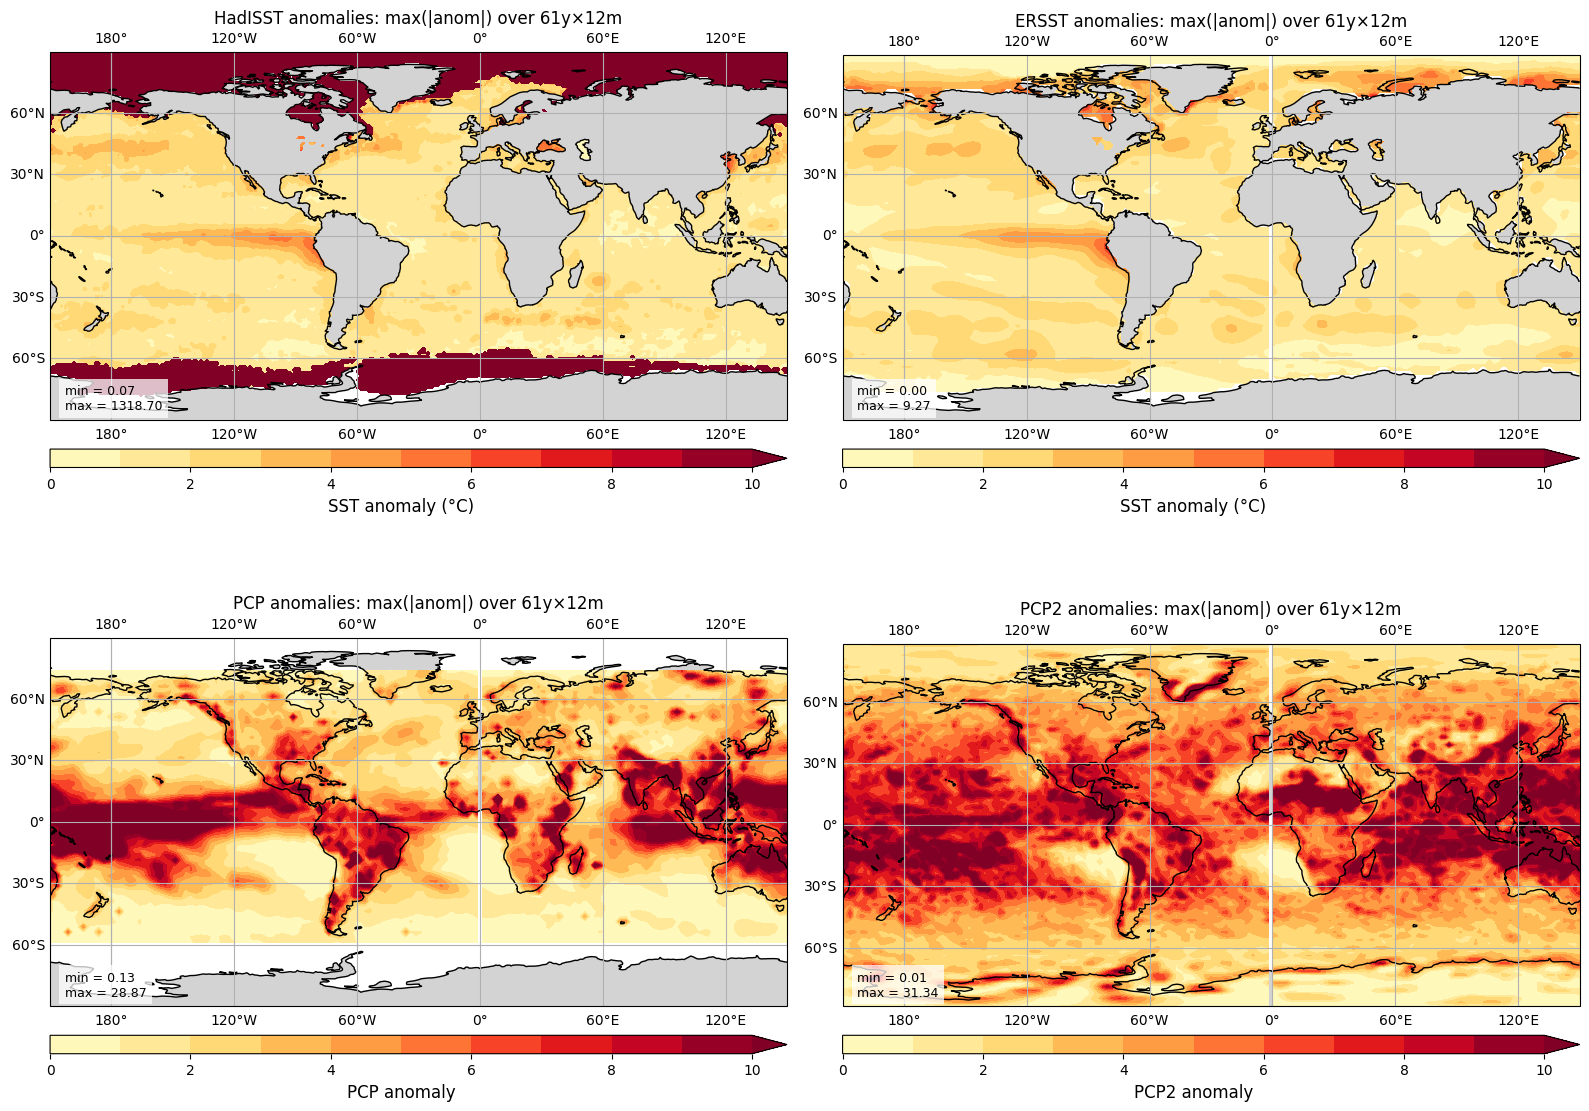

In [7]:
# Definimos la figura 2×2 para los 4 datasets
fig, axes = plt.subplots(
    2, 2,
    figsize=(16, 12),
    subplot_kw={'projection': ccrs.PlateCarree(central_longitude=330)}
)

plot_anom_summary(
    axes[0,0], lon_a, lat_a,
    anoms_a0,
    'HadISST anomalies: max(|anom|) over 61y×12m',
    cb_label='SST anomaly (°C)')

plot_anom_summary(
    axes[0,1], lon_b, lat_b,
    anoms_b,
    'ERSST anomalies: max(|anom|) over 61y×12m',
    cb_label='SST anomaly (°C)')

plot_anom_summary(
    axes[1,0], lon_pcp, lat_pcp,
    anoms_pcp,
    'PCP anomalies: max(|anom|) over 61y×12m',
    cb_label='PCP anomaly')

plot_anom_summary(
    axes[1,1], lon_pcp2, lat_pcp2,
    anoms_pcp2,
    'PCP2 anomalies: max(|anom|) over 61y×12m',
    cb_label='PCP2 anomaly')

plt.tight_layout()
plt.show()


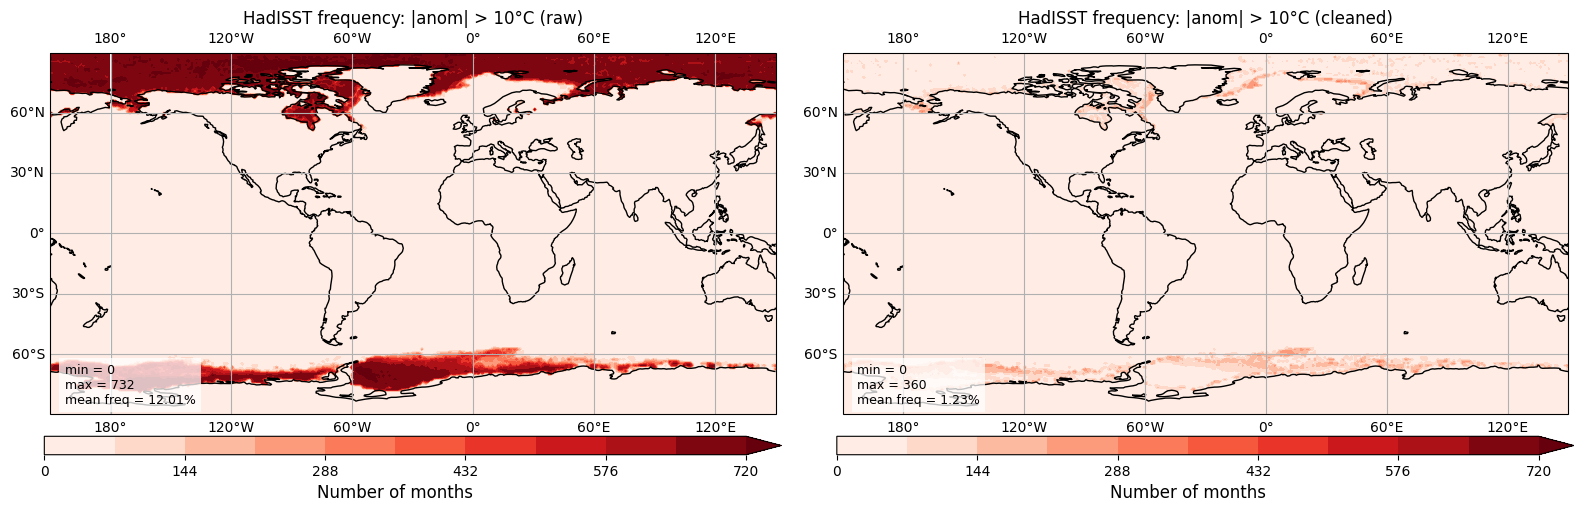

In [8]:

anoms_a = anoms_a0.copy()
bad_phys = np.abs(anoms_a0) > 20
anoms_a[bad_phys] = np.nan #eliminamos los valores que de desvian muchissimo de lo esperado para evitar outliers en anomalias, y con esto tenemos las anomalias limpias

# frecuencia absoluta: número de meses problemáticos
thr = 10
freq = np.sum(np.abs(anoms_a0) > thr, axis=(0, 1))  # (lat, lon)
n_total = anoms_a0.shape[0] * anoms_a0.shape[1]  # 61*12 = 732
freq_rel = freq / n_total

freq_c = np.sum(np.abs(anoms_a) > thr, axis=(0, 1))  # (lat, lon)
n_total = anoms_a.shape[0] * anoms_a.shape[1]  # 61*12 = 732
freq_rel_c = freq_c / n_total

def plot_freq(ax, lon, lat, freq_field, title, vmax=None):
    ax.add_feature(cfeature.COASTLINE)
    ax.add_feature(cfeature.LAND, facecolor='lightgray')
    ax.gridlines(draw_labels=True)

    if vmax is None:
        vmax = np.nanmax(freq_field)
    levels = np.linspace(0, vmax, 11)

    fill = ax.contourf(
        lon, lat, freq_field,
        levels=levels,
        transform=ccrs.PlateCarree(),
        cmap='Reds',
        extend='max'
    )

    ax.set_title(title, fontsize=12)

    cb = plt.colorbar(
        fill,
        ax=ax,
        orientation='horizontal',
        pad=0.05,
        aspect=40
    )
    cb.set_label('Number of months', fontsize=12)

    # mini-leyenda min/max
    vmin = np.nanmin(freq_field)
    vmax_f = np.nanmax(freq_field)
    n_total = 61 * 12  # meses
    freq_rel_global = np.nanmean(freq_field) / n_total

    txt = (
        f"min = {vmin:.0f}\n"
        f"max = {vmax_f:.0f}\n"
        f"mean freq = {100*freq_rel_global:.2f}%"
    )
    ax.text(
        0.02, 0.02, txt,
        transform=ax.transAxes,
        fontsize=9,
        va='bottom', ha='left',
        bbox=dict(facecolor='white', edgecolor='none', alpha=0.75)
    )

    return fill

    # Escala común para comparar
vmax_common = np.nanpercentile(np.maximum(freq, freq_c), 99)
if vmax_common < 1:
    vmax_common = np.nanmax(np.maximum(freq, freq_c))

fig, axes = plt.subplots(
    1, 2,
    figsize=(16, 5),
    subplot_kw={'projection': ccrs.PlateCarree(central_longitude=330)}
)

plot_freq(
    axes[0], lon_a, lat_a,
    freq,
    f'HadISST frequency: |anom| > {thr}°C (raw)',
    vmax=vmax_common
)

plot_freq(
    axes[1], lon_a, lat_a,
    freq_c,
    f'HadISST frequency: |anom| > {thr}°C (cleaned)',
    vmax=vmax_common
)

plt.tight_layout()
plt.show()





In [9]:
def var_mensual(var_mon, lat_src, lon_src, lat_min, lat_max, lon_min, lon_max,
                      ddeg=0.25, reducer="area_mean"):
    lon_src_180 = lon_to_180(lon_src)

    lat_t = np.arange(lat_min, lat_max + 1e-9, ddeg)
    lon_t = np.arange(lon_min, lon_max + 1e-9, ddeg)

    out = np.empty(12, dtype=float)

    for m in range(12):
        fld = interp2d_to_target(lat_src, lon_src_180, var_mon[m, :, :], lat_t, lon_t)

        if reducer == "area_mean":
            out[m] = area_weighted_mean(fld, lat_t)
        elif reducer == "mean":
            out[m] = np.nanmean(fld)
        else:
            raise ValueError("reducer must be 'area_mean' or 'mean'")

    return out

# std mensual ya calculada
var_a = np.nanstd(anoms_a, axis=0)      # (12, lat, lon)
var_b = np.nanstd(anoms_b, axis=0)
var_pcp = np.nanstd(anoms_pcp, axis=0)
var_pcp2 = np.nanstd(anoms_pcp2, axis=0)

variacion_mensual_ATL3_a  = var_mensual(var_a, lat_a, lon_a, -4,  4,  -20,    0, ddeg=0.25)
variacion_mensual_Niño_a  = var_mensual(var_a, lat_a, lon_a, -6,  6, -170, -120, ddeg=0.25)

variacion_mensual_ATL3_b  = var_mensual(var_b, lat_b, lon_b, -4,  4,  -20,    0, ddeg=0.25)
variacion_mensual_Niño_b  = var_mensual(var_b, lat_b, lon_b, -6,  6, -170, -120, ddeg=0.25)


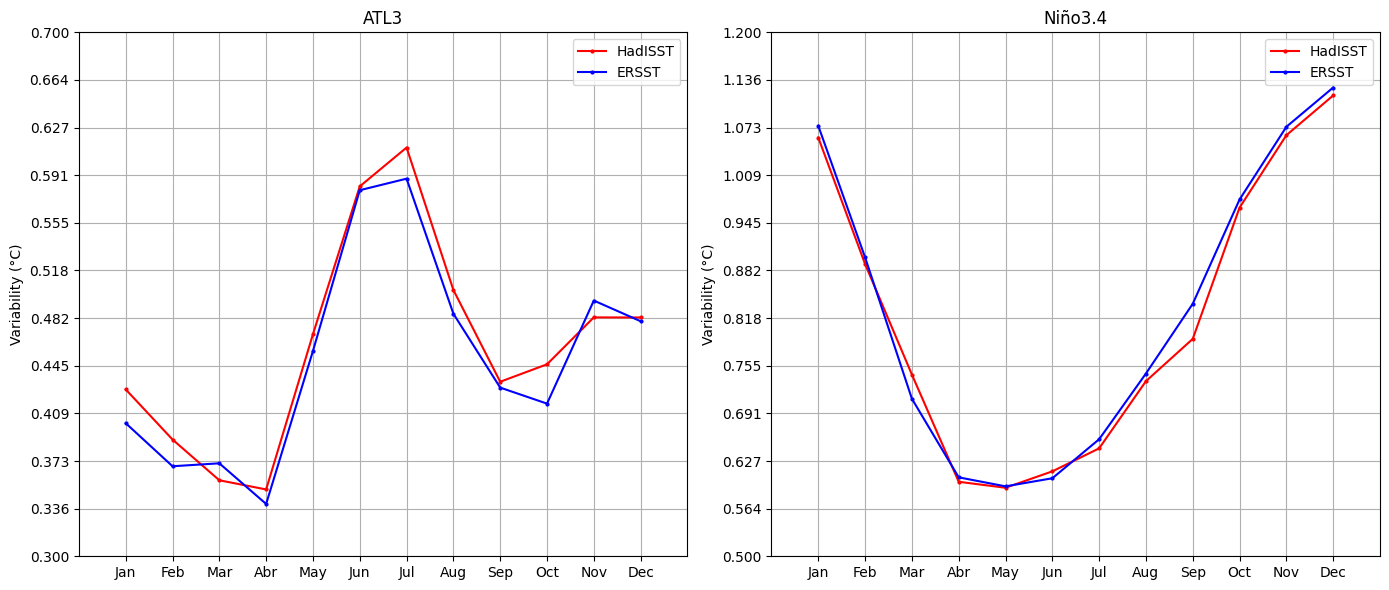

In [10]:
# Mostrar el gráfico

meses = ['Jan','Feb','Mar','Abr','May','Jun','Jul','Aug','Sep','Oct','Nov','Dec']


# SSTxATL3 y STTxNiño3.4
fig, axs = plt.subplots(1, 2, figsize=(14, 6))

axs[0].plot(meses, variacion_mensual_ATL3_a,'-ro', markersize=2)
axs[0].plot(meses, variacion_mensual_ATL3_b,'-bo', markersize=2)
axs[0].grid() # Agrega un fondo cuadriculado al gráfico
axs[0].set_ylabel('Variability (°C)') # Renombra el eje y como "Variability (°C)"
axs[0].set_title('ATL3') 
axs[0].set_yticks(np.linspace(0.3, 0.7, 12)) # Establece 9 divisiones en el eje y
axs[0].yaxis.set_major_formatter(ticker.FormatStrFormatter('%.3f')) # Formatea el eje y para mostrar solo 3 decimales
axs[0].margins(x=0.0909)
axs[0].legend(['HadISST','ERSST'])


axs[1].plot(meses, variacion_mensual_Niño_a,'-ro', markersize=2)
axs[1].plot(meses, variacion_mensual_Niño_b,'-bo', markersize=2)
axs[1].grid() # Agrega un fondo cuadriculado al gráfico
axs[1].set_ylabel('Variability (°C)') # Renombra el eje y como "Variability (°C)"
axs[1].set_title('Niño3.4') 
axs[1].set_yticks(np.linspace(0.5, 1.2, 12)) # Establece 9 divisiones en el eje y
axs[1].yaxis.set_major_formatter(ticker.FormatStrFormatter('%.3f')) # Formatea el eje y para mostrar solo 3 decimales
axs[1].margins(x=0.0909)
axs[1].legend(['HadISST','ERSST'])

plt.tight_layout()
plt.show()


<div style="
background-color:#f7f7f7;
border-left:5px solid #444;
padding:14px;
border-radius:4px;
">

<b>Variabilidad media mensual de las SST (61 años)</b><br><br>
Aquí se muestra la variabilidad media de las anomalías de SST calculada a partir de 61 años de datos,
para cada mes del año, en las regiones <b>ATL3</b> y <b>Niño3.4</b>, comparando las bases de datos 
<span style="color:#d62728;"><b>HadISST</b></span> y 
<span style="color:#1f77b4;"><b>ERSST</b></span>.

Esta variabilidad identifica los periodos del año en los que los fenómenos océano-atmosféricos
presentan mayor intensidad:

<ul>
<li>
<b>Atlantic Niño (ATL3):</b>
máxima actividad durante el verano boreal, con picos en
<b>junio y julio</b>.
</li>

<li>
<b>Pacific Niño (Niño3.4):</b>
máxima actividad durante el invierno boreal, con picos en
<b>diciembre y enero</b>.
</li>
</ul>

Las diferencias entre ambas bases de datos se encuentran dentro de lo esperado.
En el caso de ATL3, 
<span style="color:#d62728;">HadISST</span> presenta picos y mínimos ligeramente más elevados
que <span style="color:#1f77b4;">ERSST</span>.

La separación <b>relativa</b> entre 
<span style="color:#d62728;">HadISST</span> y 
<span style="color:#1f77b4;">ERSST</span>
es mayor en el Atlantic Niño, lo que se aprecia visualmente en el gráfico.
En contraste, el Niño del Pacífico muestra una señal mucho más similar entre ambas bases de datos.


No obstante, en términos absolutos, las diferencias entre HadISST y ERSST son comparables en ambos
casos (≈ 0.05 °C). Por tanto, ATL3 no es más inconsistente en terminos absolutos, es solo que el mismo sesgo de datos
tiene un mayor peso relativo cuando la variabilidad climática es menor.


</div>



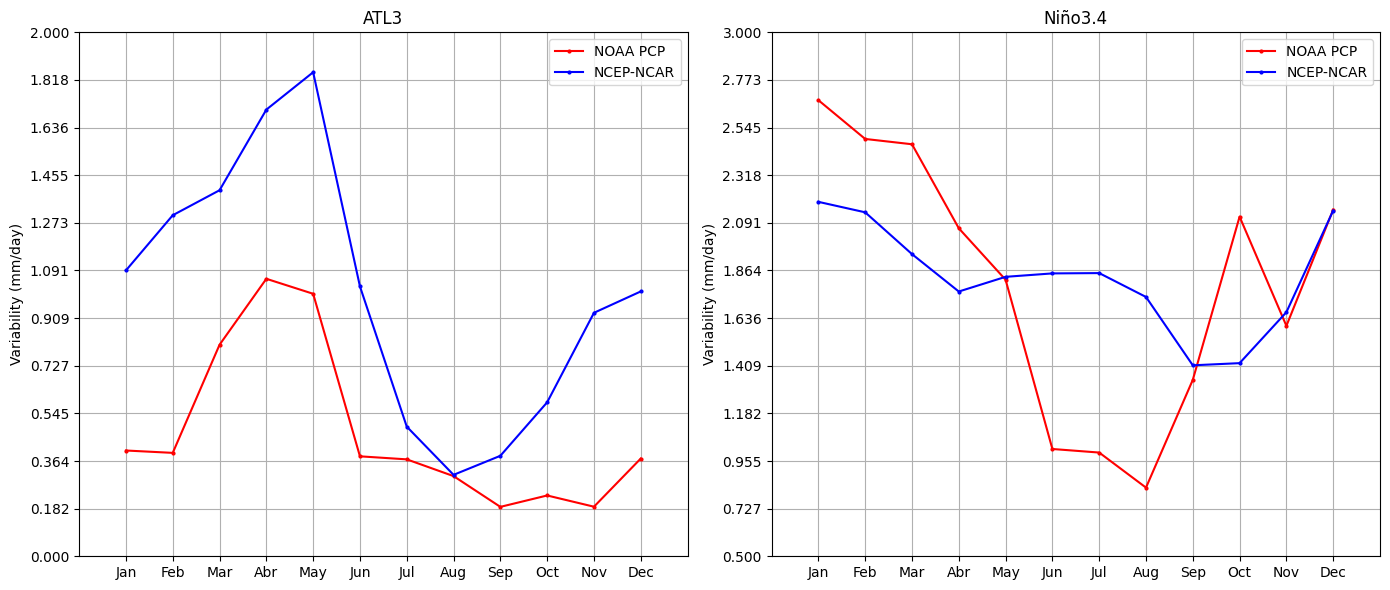

In [11]:
variacion_mensual_ATL3_pcp  = var_mensual(var_pcp, lat_pcp, lon_pcp, -4,  4,  -20,    0, ddeg=0.25)
variacion_mensual_Niño_pcp  = var_mensual(var_pcp, lat_pcp, lon_pcp, -6,  6, -170, -120, ddeg=0.25)

variacion_mensual_ATL3_pcp2  = var_mensual(var_pcp2, lat_pcp2, lon_pcp2, -4,  4,  -20,    0, ddeg=0.25)
variacion_mensual_Niño_pcp2  = var_mensual(var_pcp2, lat_pcp2, lon_pcp2, -6,  6, -170, -120, ddeg=0.25)

# SSTxATL3 y STTxNiño3.4
fig, axs = plt.subplots(1, 2, figsize=(14, 6))

axs[0].plot(meses, variacion_mensual_ATL3_pcp,'-ro', markersize=2)
axs[0].plot(meses, variacion_mensual_ATL3_pcp2,'-bo', markersize=2)
axs[0].grid() # Agrega un fondo cuadriculado al gráfico
axs[0].set_ylabel('Variability (mm/day)') # Renombra el eje y como "Variability (°C)"
axs[0].set_title('ATL3') 
axs[0].set_yticks(np.linspace(0, 2, 12)) # Establece 9 divisiones en el eje y
axs[0].yaxis.set_major_formatter(ticker.FormatStrFormatter('%.3f')) # Formatea el eje y para mostrar solo 3 decimales
axs[0].margins(x=0.0909)
axs[0].legend(['NOAA PCP','NCEP-NCAR'])


axs[1].plot(meses, variacion_mensual_Niño_pcp,'-ro', markersize=2)
axs[1].plot(meses, variacion_mensual_Niño_pcp2,'-bo', markersize=2)
axs[1].grid() # Agrega un fondo cuadriculado al gráfico
axs[1].set_ylabel('Variability (mm/day)') # Renombra el eje y como "Variability (°C)"
axs[1].set_title('Niño3.4') 
axs[1].set_yticks(np.linspace(0.5, 3, 12)) # Establece 9 divisiones en el eje y
axs[1].yaxis.set_major_formatter(ticker.FormatStrFormatter('%.3f')) # Formatea el eje y para mostrar solo 3 decimales
axs[1].margins(x=0.0909)
axs[1].legend(['NOAA PCP','NCEP-NCAR'])

plt.tight_layout()
plt.show()




<div style="
background-color:#f7f7f7;
border-left:5px solid #444;
padding:14px;
border-radius:4px;
">
A diferencia de la SST, la variabilidad mensual de la precipitación muestra una mayor dependencia del producto utilizado. NOAA PCP y NCEP-NCAR presentan ciclos estacionales coherentes en ATL3 y Niño-3.4, pero con diferencias notables en amplitud y fase, especialmente en el Pacífico ecuatorial. Estas discrepancias son esperables dada la naturaleza altamente no lineal de la precipitación y las limitaciones de los reanálisis antiguos en regiones tropicales.

</div>



In [12]:
#Vamos a definir los indices globales como las anomalias entre la variabilidad
index_sst_a = anoms_a / var_a        #HadISST
index_sst_b = anoms_b / var_b        #ERSST
index_pcp = anoms_pcp / var_pcp      #NOAA PCP
index_pcp2 = anoms_pcp2 / var_pcp2   #NCEP-NCAR 

#A partir de estos indices vamos a calcular su media temporal en los meses de mayor intensidad de cada evento, tendremos como resultado matrices 2D delimitadas por las zonas
JJ_months = [5, 6]
ND_months = [10, 11]

index_sst_a_JJ = np.nanmean(index_sst_a[:, JJ_months, :, :], axis=1)
index_sst_a_ND = np.nanmean(index_sst_a[:, ND_months, :, :], axis=1)

index_sst_b_JJ = np.nanmean(index_sst_b[:, JJ_months, :, :], axis=1)
index_sst_b_ND = np.nanmean(index_sst_b[:, ND_months, :, :], axis=1)

index_pcp_JJ = np.nanmean(index_pcp[:, JJ_months, :, :], axis=1)
index_pcp_ND = np.nanmean(index_pcp[:, ND_months, :, :], axis=1)

index_pcp2_JJ = np.nanmean(index_pcp2[:, JJ_months, :, :], axis=1)
index_pcp2_ND = np.nanmean(index_pcp2[:, ND_months, :, :], axis=1)

#Tambien vamos a calcular la media de estos indices en la zona de cada evento.

# Regiones (en coordenadas físicas)
ATL3_lat = (-4.0, 4.0)
ATL3_lon = (340.0, 360.0)      # 20W–0E en 0–360

NINO_lat = (-6.0, 6.0)
NINO_lon = (190.0, 240.0)      # 170W–120W en 0–360

#Vamos a crear una funcion donde podamos delimitar la zona para cualquier base de datos a partir de las coordenadas físicas y hacer su media
#Anteriormente para la variabilidad cogimos las medidas de la rejilla directamente aun que no fueran las zonas exactas 
#pero como la variabilidad en ATL3 es baja eso hace que el indice sea más alto y los errores escalan con eso

def _to_0_360(lon):
    lon = np.asarray(lon)
    return np.mod(lon, 360.0)

def _lon_mask_0_360(lon0_360, lon_min, lon_max):
    lon_min = lon_min % 360.0
    lon_max = lon_max % 360.0
    if lon_min <= lon_max:
        return (lon0_360 >= lon_min) & (lon0_360 <= lon_max)
    else:
        return (lon0_360 >= lon_min) | (lon0_360 <= lon_max)

def area_mean_index(season_field, lat, lon, lat_bounds, lon_bounds_0_360):
    lat = np.asarray(lat)
    lon0 = _to_0_360(lon)

    lat_min, lat_max = lat_bounds
    lon_min, lon_max = lon_bounds_0_360

    lat_mask = (lat >= lat_min) & (lat <= lat_max)
    lon_mask = _lon_mask_0_360(lon0, lon_min, lon_max)

    sub = season_field[:, lat_mask, :][:, :, lon_mask]
    return np.nanmean(sub, axis=(1, 2))
    
#Vamos a coger los indices en forma de matriz anteriores y les vamos a calcular la media de temperatura para cada zona especifica, este indice resultantante solo tendra dimension temporal
# Hadisst
ATL3_sst_a_index = area_mean_index(index_sst_a_JJ, lat_a, lon_a, ATL3_lat, ATL3_lon)
Niño_sst_a_index = area_mean_index(index_sst_a_ND, lat_a, lon_a, NINO_lat, NINO_lon) 

# ERSST
ATL3_sst_b_index = area_mean_index(index_sst_b_JJ, lat_b, lon_b, ATL3_lat, ATL3_lon)
Niño_sst_b_index = area_mean_index(index_sst_b_ND, lat_b, lon_b, NINO_lat, NINO_lon)  
    
# NOAA PCP
ATL3_pcp_index = area_mean_index(index_pcp_JJ, lat_pcp, lon_pcp, ATL3_lat, ATL3_lon)
Niño_pcp_index = area_mean_index(index_pcp_ND, lat_pcp, lon_pcp, NINO_lat, NINO_lon) 

# #NCEP-NCAR
ATL3_pcp2_index = area_mean_index(index_pcp2_JJ, lat_pcp2, lon_pcp2, ATL3_lat, ATL3_lon)
Niño_pcp2_index = area_mean_index(index_pcp2_ND, lat_pcp2, lon_pcp2, NINO_lat, NINO_lon)

#Una vez tenemos los indices vamos a calcular la media de anomalies en en los messes de Julio Junio y de Noviembre Diciembre, estas son globales
anoms_a_JJ = np.mean(anoms_a[:,JJ_months,:,:], axis=1)
anoms_b_JJ = np.mean(anoms_b[:,JJ_months,:,:], axis=1)
anoms_pcp_JJ = np.mean(anoms_pcp[:,JJ_months,:,:], axis=1)
anoms_pcp2_JJ = np.mean(anoms_pcp2[:,JJ_months,:,:], axis=1)

anoms_a_ND = np.mean(anoms_a[:,ND_months,:,:], axis=1)
anoms_b_ND = np.mean(anoms_b[:,ND_months,:,:], axis=1)
anoms_pcp_ND = np.mean(anoms_pcp[:,ND_months,:,:], axis=1)
anoms_pcp2_ND = np.mean(anoms_pcp2[:,ND_months,:,:], axis=1)

#Vamos a definir una funcion donde poder ver la tendencia y las correlacion entre estas anomalias en los periodos JJ y ND y su indice normalizado y medio de cada zona  
# Analizamos en qué regiones del mundo las anomalías de SST o precipitación
# covarían con el índice regional (ATL3 o Niño3.4).
# Las zonas con alta correlación indican regiones donde la variabilidad
# interanual está fuertemente acoplada al índice, por lo tanto al evento climatico

def find_a_r(anom_det, index):
    index = np.asarray(index)
    n_time = len(index)

    x = index
    x_mean = np.mean(x)
    x_centered = x - x_mean

    y = anom_det  # (time, lat, lon)
    y_mean = np.mean(y, axis=0, keepdims=True)
    y_centered = y - y_mean

    cov = np.sum(x_centered[:, np.newaxis, np.newaxis] * y_centered, axis=0) / (n_time - 1)
    var_x = np.var(x, ddof=1)
    slopes = cov / var_x

    std_y = np.std(y, axis=0, ddof=1)
    correlations = cov / (np.std(x, ddof=1) * std_y)

    return slopes, correlations
    

In [13]:
a_HADISST_ATL3, corr_HADISST_ATL3 = find_a_r(anoms_a_JJ, ATL3_sst_a_index)

a_HADISST_NIÑO, corr_HADISST_NIÑO = find_a_r(anoms_a_ND, Niño_sst_a_index)

a_ERSST_ATL3, corr_ERSST_ATL3 = find_a_r(anoms_b_JJ, ATL3_sst_b_index)

a_ERSST_NIÑO, corr_ERSST_NIÑO = find_a_r(anoms_b_ND, Niño_sst_b_index)

a_pcp_ATL3, corr_pcp_ATL3 = find_a_r(anoms_pcp_JJ, ATL3_pcp_index)

a_pcp_NIÑO, corr_pcp_NIÑO = find_a_r(anoms_pcp_ND, Niño_pcp_index)

a_pcp2_ATL3, corr_pcp2_ATL3 = find_a_r(anoms_pcp2_JJ, ATL3_pcp2_index)

a_pcp2_NIÑO, corr_pcp2_NIÑO = find_a_r(anoms_pcp2_ND, Niño_pcp2_index)

def configure_plot(ax, title, cb_label, data_type='temp'):
    ax.add_feature(cfeature.COASTLINE)
    ax.add_feature(cfeature.LAND, facecolor='lightgray')
    ax.gridlines(draw_labels=True)

    cmap = plt.cm.RdBu_r
    clev = np.linspace(-1, 1, 11)

    return cmap, clev
    
def create_plot(ax, lon, lat, slope_data, corr_data, title, cb_label, data_type='temp'):
    # --- Constantes del estudio ---
    N = 61
    alpha = 0.05
    df = N - 2

    # --- Base map ---
    ax.add_feature(cfeature.COASTLINE)
    ax.add_feature(cfeature.LAND, facecolor='lightgray')
    ax.gridlines(draw_labels=True)

    cmap = plt.cm.RdBu_r

    slope_plot = np.array(slope_data, copy=True)
    corr_plot  = np.array(corr_data,  copy=True)

    # COLORES-SLOPE
    if data_type == 'temp':
        clev_slope = np.linspace(-1, 1, 11)
    else:
        vmax = np.nanpercentile(np.abs(slope_plot), 95)
        vmax = max(min(vmax, 2.0), 1e-6)
        clev_slope = np.linspace(-vmax, vmax, 11)

    fill = ax.contourf(
        lon, lat, slope_plot,
        levels=clev_slope,
        transform=ccrs.PlateCarree(),
        cmap=cmap,
        extend='both'
    )

    
    #CONTORNOS = r (tamaño de correlación)
    corr_levels = [-0.6, -0.4, -0.2, 0.2, 0.4, 0.6]
    cont = ax.contour(lon, lat, corr_plot,levels=corr_levels,transform=ccrs.PlateCarree(),colors='k',linewidths=0.7,alpha=0.7)
    ax.clabel(cont, inline=True, fontsize=8, fmt="%.1f")

    
    #HACHURADO = p < 0.05 (significancia de r)
    r = np.clip(corr_plot, -0.999999, 0.999999)
    t_stat = r * np.sqrt(df / (1.0 - r**2))
    pval = 2.0 * stats.t.sf(np.abs(t_stat), df)
    sig = (pval < alpha).astype(int)  # 1 significativo
    ax.contourf(lon, lat, sig,levels=[0.5, 1.5],transform=ccrs.PlateCarree(),colors='none',hatches=['....'])  # cambia a '///' si lo prefieres)

    # --- Título y colorbar ---
    ax.set_title(title, fontsize=12)

    cb = plt.colorbar(
        fill,
        ax=ax,
        orientation='horizontal',
        pad=0.05,
        aspect=40
    )
    cb.set_label(cb_label, fontsize=12)

    return fill

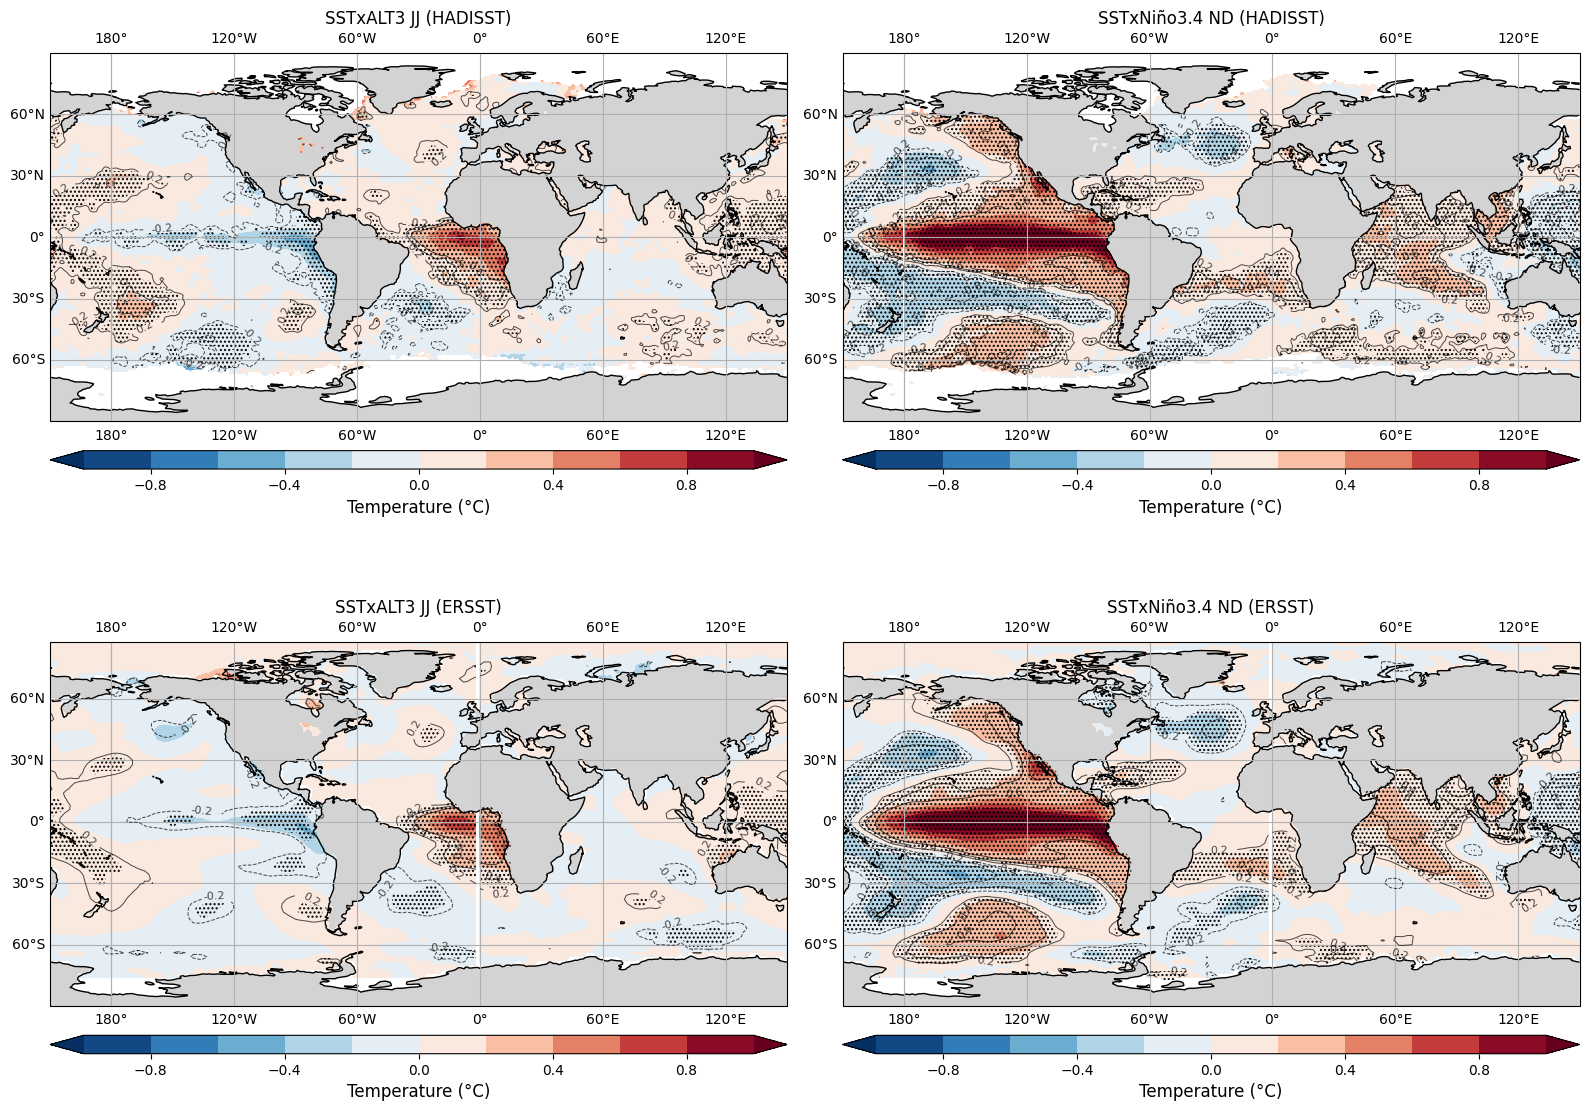

In [14]:
# SSTxATL3 y STTxNiño3.4
fig, axes = plt.subplots(
    2, 2,
    figsize=(16, 12),
    subplot_kw={'projection': ccrs.PlateCarree(central_longitude=330)}
)

create_plot(
    axes[0,0], lon_a, lat_a,
    a_HADISST_ATL3, corr_HADISST_ATL3,
    'SSTxALT3 JJ (HADISST)', 'Temperature (°C)'
)

create_plot(
    axes[0,1], lon_a, lat_a,
    a_HADISST_NIÑO, corr_HADISST_NIÑO,
    'SSTxNiño3.4 ND (HADISST)', 'Temperature (°C)'
)

create_plot(
    axes[1,0], lon_b, lat_b,
    a_ERSST_ATL3, corr_ERSST_ATL3,
    'SSTxALT3 JJ (ERSST)', 'Temperature (°C)'
)

create_plot(
    axes[1,1], lon_b, lat_b,
    a_ERSST_NIÑO, corr_ERSST_NIÑO,
    'SSTxNiño3.4 ND (ERSST)', 'Temperature (°C)'
)

plt.tight_layout()
plt.show()



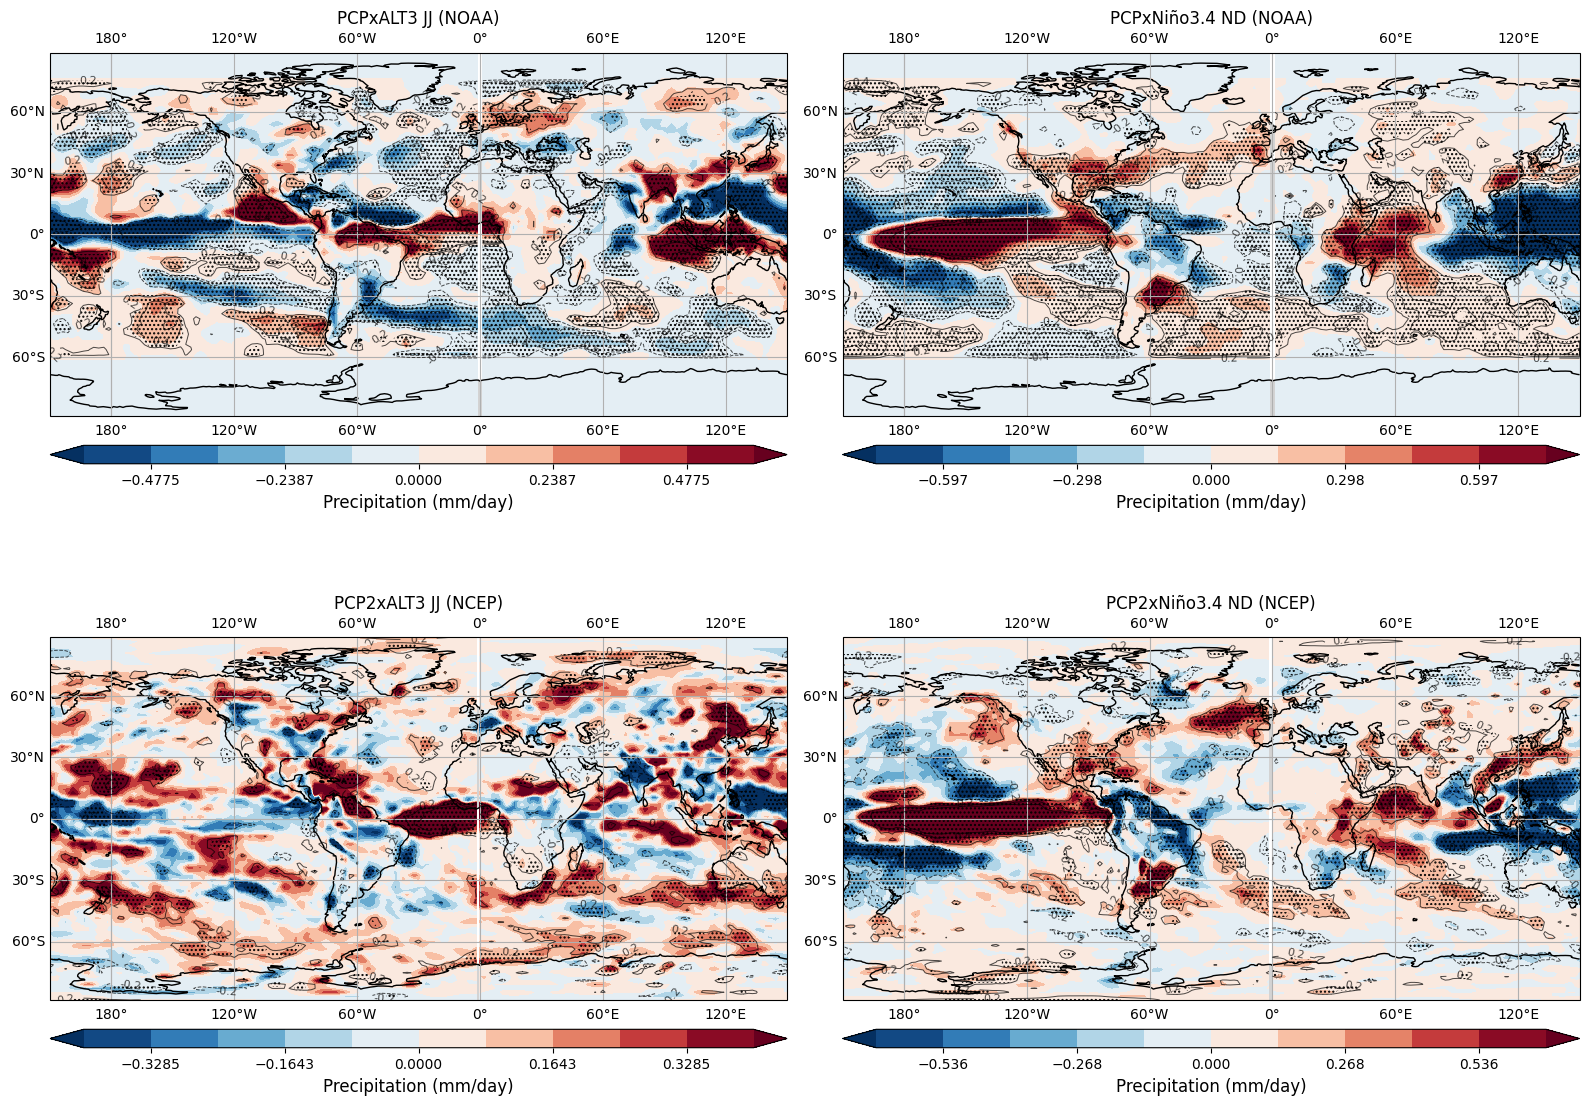

In [15]:
# PCPxATL3 y PCPxNiño3.4
fig, axes = plt.subplots(
    2, 2,
    figsize=(16, 12),
    subplot_kw={'projection': ccrs.PlateCarree(central_longitude=330)}
)

create_plot(
    axes[0,0], lon_pcp, lat_pcp,
    a_pcp_ATL3, corr_pcp_ATL3,
    'PCPxALT3 JJ (NOAA)', 'Precipitation (mm/day)', 'precip'
)

create_plot(
    axes[0,1], lon_pcp, lat_pcp,
    a_pcp_NIÑO, corr_pcp_NIÑO,
    'PCPxNiño3.4 ND (NOAA)', 'Precipitation (mm/day)', 'precip'
)

create_plot(
    axes[1,0], lon_pcp2, lat_pcp2,
    a_pcp2_ATL3, corr_pcp2_ATL3,
    'PCP2xALT3 JJ (NCEP)', 'Precipitation (mm/day)', 'precip'
)

create_plot(
    axes[1,1], lon_pcp2, lat_pcp2,
    a_pcp2_NIÑO, corr_pcp2_NIÑO,
    'PCP2xNiño3.4 ND (NCEP)', 'Precipitation (mm/day)', 'precip'
)
 
plt.tight_layout()
plt.show()


In [16]:

N = 5

def top5(years, a, b, n=5):
    comb = (a + b) / 2
    idx = np.argsort(comb)[-n:]
    df = pd.DataFrame({"Año": years[idx], "HadISST (°C)": a[idx], "ERSST (°C)": b[idx]})
    return df.sort_values("Año").set_index("Año")

atl3 = top5(years, Temp_ATL3_a, Temp_ATL3_b, N)
nino = top5(years, Temp_Niño_a, Temp_Niño_b, N)

fmt = {"HadISST (°C)": "{:.2f}", "ERSST (°C)": "{:.2f}"}
header_style = [{"selector":"th","props":[("padding-top","2px"),("padding-bottom","2px"),
                                         ("vertical-align","bottom"),("text-align","center")]}]

s_atl3 = atl3.style.format(fmt).set_properties(**{"text-align":"center"}).set_table_styles(header_style)
s_nino = nino.style.format(fmt).set_properties(**{"text-align":"center"}).set_table_styles(header_style)

html = f"""
<div style="text-align:left; font-weight:bold; font-size:15px; margin-bottom:12px;">
Picos de SST media anual (1960–2020)
</div>

<div style="display:flex; justify-content:left; gap:80px;">
  <div>
    <div style="font-weight:bold; margin-bottom:6px;">Atlantic Niño (ATL3):</div>
    {s_atl3.to_html()}
  </div>
  <div>
    <div style="font-weight:bold; margin-bottom:6px;">Pacific Niño (Niño 3.4):</div>
    {s_nino.to_html()}
  </div>
</div>
"""

display(HTML(html))

<div style="
background-color:#f7f7f7;
border-left:5px solid #444;
padding:14px;
border-radius:4px;
">
<b>Identificación de años de máxima intensidad térmica</b><br><br>

En esta sección se identifican los <b>cinco años con mayores picos de temperatura</b> en las regiones
<b>Niño&nbsp;3.4</b> y <b>ATL3</b> durante el periodo 1960–2020.
Dado que los episodios de calentamiento asociados a estos fenómenos presentan una recurrencia
característica, los máximos térmicos detectados pueden interpretarse como
<b>indicadores de la posible ocurrencia de eventos Niño</b> en cada una de las regiones.
<br><br>
Estos años se utilizan posteriormente para analizar si efectivamente se produjeron
eventos de <b>Pacific Niño</b> en la región Niño&nbsp;3.4 y de <b>Atlantic Niño</b> en la región ATL3,
así como para investigar posibles interacciones entre ambos sistemas.
Cabe destacar que los <b>picos térmicos, por sí solos, no constituyen una prueba concluyente</b>
de la ocurrencia de estos eventos.
Sin embargo, mediante el análisis de las anomalías de SST y su comparación con la
<b>variabilidad media mensual</b> característica de cada región,
es posible determinar si dichos años corresponden efectivamente a episodios Niño.
Este enfoque permite profundizar en la detección y caracterización de estos eventos climáticos
de forma robusta y consistente.
</div>

In [17]:
def mensual_region(mon_field, lat_src, lon_src, lat_min, lat_max, lon_min, lon_max,
                   ddeg=0.25, reducer="area_mean"):
    """
    MISMA ESTRUCTURA que var_mensual, pero:
    - mon_field es un campo mensual (12, lat, lon) de ANOMALÍAS de 1 año concreto.
    Devuelve: (12,) serie mensual regional.
    """
    lon_src_180 = lon_to_180(lon_src)

    lat_t = np.arange(lat_min, lat_max + 1e-9, ddeg)
    lon_t = np.arange(lon_min, lon_max + 1e-9, ddeg)

    out = np.empty(12, dtype=float)

    for m in range(12):
        fld = interp2d_to_target(lat_src, lon_src_180, mon_field[m, :, :], lat_t, lon_t)

        if reducer == "area_mean":
            out[m] = area_weighted_mean(fld, lat_t)
        elif reducer == "mean":
            out[m] = np.nanmean(fld)
        else:
            raise ValueError("reducer must be 'area_mean' or 'mean'")

    return out


def anom_year(year, anoms, year0=1960):
    """
    Extrae anomalías mensuales (12, lat, lon) para un año.
    anoms: (nyears, 12, lat, lon)
    """
    if year < year0:
        raise ValueError(f"No hay datos anteriores a {year0}")
    i = year - year0
    if i < 0 or i >= anoms.shape[0]:
        year_last = year0 + anoms.shape[0] - 1
        raise ValueError(f"Año fuera de rango. Disponible: {year0}–{year_last}")
    return anoms[i, :, :, :]
    

def center_on_jan(series12, shift=6):
    """
    Reordena una serie mensual (12,) para centrar el ciclo en Jan/Dec.
    shift=6 coloca Jan/Dec en el centro del eje.
    """
    return np.roll(series12, -shift)
def center_month_labels(months, shift=6):
    return months[shift:] + months[:shift]
    
def niño_monthly_series(year,lat_min_n, lat_max_n, lon_min_n, lon_max_n):
    anom_a_y = anom_year(year, anoms_a, year0=1960)
    anom_b_y = anom_year(year, anoms_b, year0=1960)

    niño_a = mensual_region(anom_a_y, lat_a, lon_a, lat_min_n, lat_max_n, lon_min_n, lon_max_n, ddeg=0.25)
    niño_b = mensual_region(anom_b_y, lat_b, lon_b, lat_min_n, lat_max_n, lon_min_n, lon_max_n, ddeg=0.25)
    return niño_a, niño_b
# como los maximos son en NDJ veremos el ENSO en dos años por eso representaremos el grafico en 2 años
# centramos el ciclo mensual en Jan/De para verlo mejor ya que entre año y año el maximo no se corta y centrandolo para el anual tampoco lo hara
meses_c = center_month_labels(meses, shift=6)

var_niño_a_c = center_on_jan(variacion_mensual_Niño_a, shift=6)
var_niño_b_c = center_on_jan(variacion_mensual_Niño_b, shift=6)

lat_min_enso, lat_max_enso, lon_min_enso, lon_max_enso = -6, 6, -170, -120
lat_min_atl3, lat_max_atl3, lon_min_atl3, lon_max_atl3 = -4, 4, -20, 0


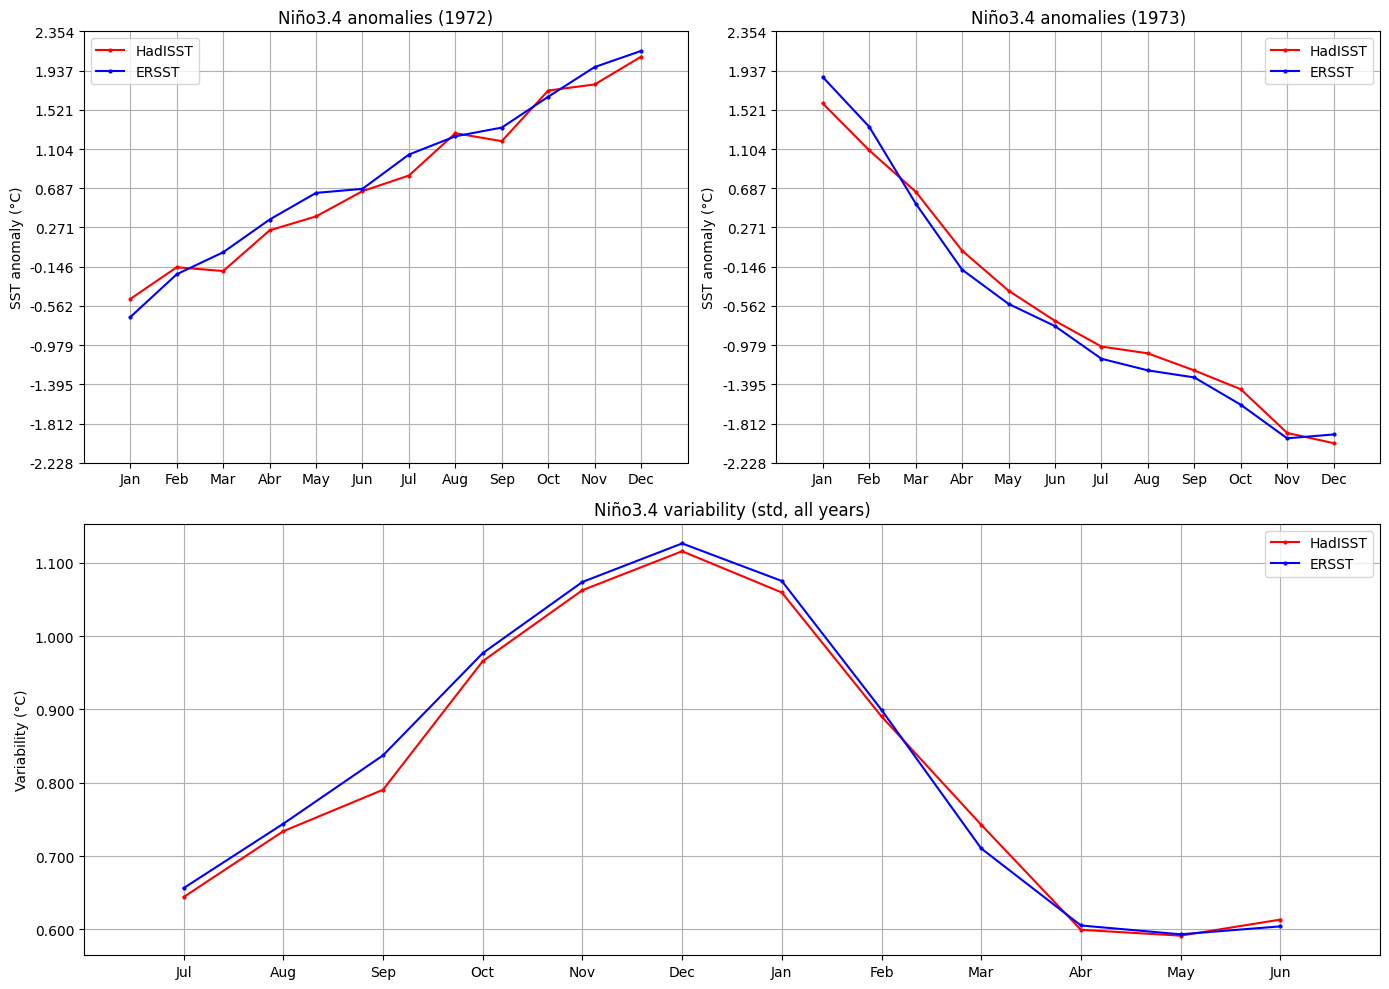

In [18]:
#POSSIBLE ENSO ENTRE 1972-1973

year1 = 1972
year2 = 1973 

niño1_a, niño1_b = niño_monthly_series(year1,lat_min_enso, lat_max_enso, lon_min_enso, lon_max_enso)
niño2_a, niño2_b = niño_monthly_series(year2,lat_min_enso, lat_max_enso, lon_min_enso, lon_max_enso)

ymin = np.nanmin([niño1_a.min(), niño1_b.min(),niño2_a.min(), niño2_b.min()])
ymax = np.nanmax([niño1_a.max(), niño1_b.max(),niño2_a.max(), niño2_b.max()]) #asi definimos los limites de nuestro eje y y los hacemos comunes para año1 y 2

pad = 0.05 * (ymax - ymin)
ymin -= pad
ymax += pad

fig = plt.figure(figsize=(14, 10))

#2 columnas para arriba; abajo 1 eje centrado ocupando ambas columnas
gs = fig.add_gridspec(2, 2, height_ratios=[1, 1])

ax00 = fig.add_subplot(gs[0, 0])   # año1
ax01 = fig.add_subplot(gs[0, 1])   # año2
ax10 = fig.add_subplot(gs[1, :])   # variabilidad (ocupa 2 columnas -> centrado, mismo alto)

# Primer Año : anomalías mensuales ---
ax00.plot(meses, niño1_a, '-ro', markersize=2)
ax00.plot(meses, niño1_b, '-bo', markersize=2)
ax00.grid()
ax00.set_ylim(ymin, ymax)
ax00.set_yticks(np.linspace(ymin, ymax, 12))

ax00.set_ylabel('SST anomaly (°C)')
ax00.set_title(f'Niño3.4 anomalies ({year1})')

ax00.yaxis.set_major_formatter(ticker.FormatStrFormatter('%.3f'))
ax00.margins(x=0.0909)
ax00.legend(['HadISST','ERSST'])

#Segundo Año: anomalías mensuales ---
ax01.plot(meses, niño2_a, '-ro', markersize=2)
ax01.plot(meses, niño2_b, '-bo', markersize=2)
ax01.grid()
ax01.set_ylim(ymin, ymax)
ax01.set_yticks(np.linspace(ymin, ymax, 12))

ax01.set_ylabel('SST anomaly (°C)')
ax01.set_title(f'Niño3.4 anomalies ({year2})')
ax01.yaxis.set_major_formatter(ticker.FormatStrFormatter('%.3f'))
ax01.margins(x=0.0909)
ax01.legend(['HadISST','ERSST'])

# --- (3) Variabilidad mensual climatológica (una sola vez) ---
ax10.plot(meses_c, var_niño_a_c, '-ro', markersize=2)
ax10.plot(meses_c, var_niño_b_c, '-bo', markersize=2)
ax10.grid()
ax10.set_ylabel('Variability (°C)')
ax10.set_title('Niño3.4 variability (std, all years)')
ax10.yaxis.set_major_formatter(ticker.FormatStrFormatter('%.3f'))
ax10.margins(x=0.0909)
ax10.legend(['HadISST','ERSST'])

plt.tight_layout()
plt.show()

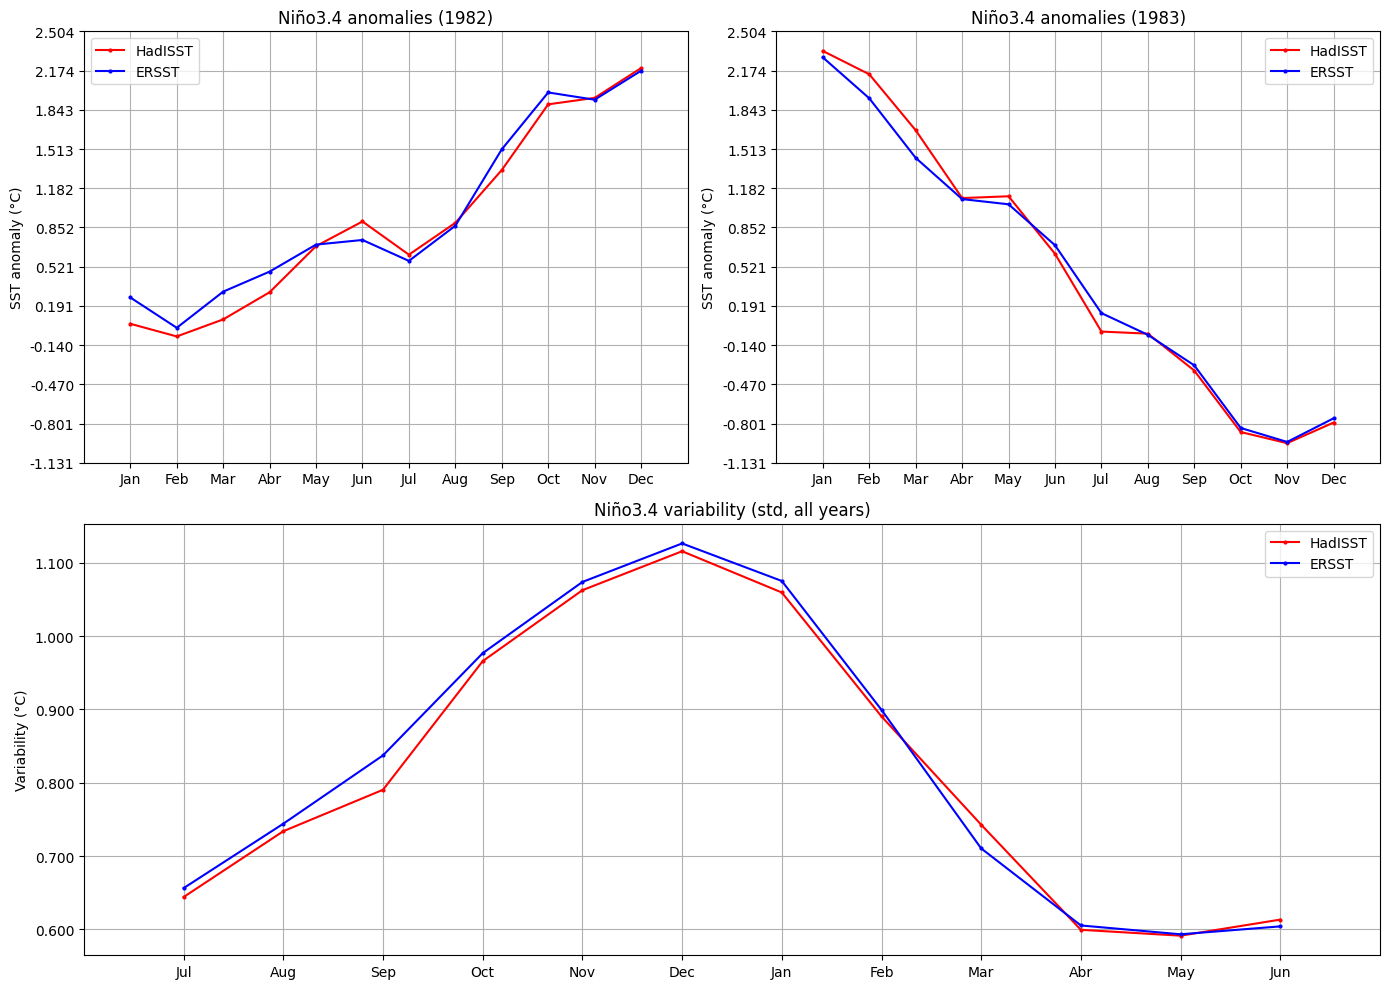

In [19]:
#POSSIBLE ENSO ENTRE 1982-1983

year1 = 1982
year2 = 1983

niño1_a, niño1_b = niño_monthly_series(year1,lat_min_enso, lat_max_enso, lon_min_enso, lon_max_enso)
niño2_a, niño2_b = niño_monthly_series(year2,lat_min_enso, lat_max_enso, lon_min_enso, lon_max_enso)

ymin = np.nanmin([niño1_a.min(), niño1_b.min(),niño2_a.min(), niño2_b.min()])
ymax = np.nanmax([niño1_a.max(), niño1_b.max(),niño2_a.max(), niño2_b.max()])

pad = 0.05 * (ymax - ymin)
ymin -= pad
ymax += pad

fig = plt.figure(figsize=(14, 10))

#2 columnas para arriba; abajo 1 eje centrado ocupando ambas columnas
gs = fig.add_gridspec(2, 2, height_ratios=[1, 1])

ax00 = fig.add_subplot(gs[0, 0])   # año1
ax01 = fig.add_subplot(gs[0, 1])   # año2
ax10 = fig.add_subplot(gs[1, :])   # variabilidad (ocupa 2 columnas -> centrado, mismo alto)

# Primer Año : anomalías mensuales ---
ax00.plot(meses, niño1_a, '-ro', markersize=2)
ax00.plot(meses, niño1_b, '-bo', markersize=2)
ax00.grid()
ax00.set_ylim(ymin, ymax)
ax00.set_yticks(np.linspace(ymin, ymax, 12))

ax00.set_ylabel('SST anomaly (°C)')
ax00.set_title(f'Niño3.4 anomalies ({year1})')

ax00.yaxis.set_major_formatter(ticker.FormatStrFormatter('%.3f'))
ax00.margins(x=0.0909)
ax00.legend(['HadISST','ERSST'])

#Segundo Año: anomalías mensuales ---
ax01.plot(meses, niño2_a, '-ro', markersize=2)
ax01.plot(meses, niño2_b, '-bo', markersize=2)
ax01.grid()
ax01.set_ylim(ymin, ymax)
ax01.set_yticks(np.linspace(ymin, ymax, 12))

ax01.set_ylabel('SST anomaly (°C)')
ax01.set_title(f'Niño3.4 anomalies ({year2})')
ax01.yaxis.set_major_formatter(ticker.FormatStrFormatter('%.3f'))
ax01.margins(x=0.0909)
ax01.legend(['HadISST','ERSST'])

# --- (3) Variabilidad mensual climatológica (una sola vez) ---
ax10.plot(meses_c, var_niño_a_c, '-ro', markersize=2)
ax10.plot(meses_c, var_niño_b_c, '-bo', markersize=2)
ax10.grid()
ax10.set_ylabel('Variability (°C)')
ax10.set_title('Niño3.4 variability (std, all years)')
ax10.yaxis.set_major_formatter(ticker.FormatStrFormatter('%.3f'))
ax10.margins(x=0.0909)
ax10.legend(['HadISST','ERSST'])

plt.tight_layout()
plt.show()

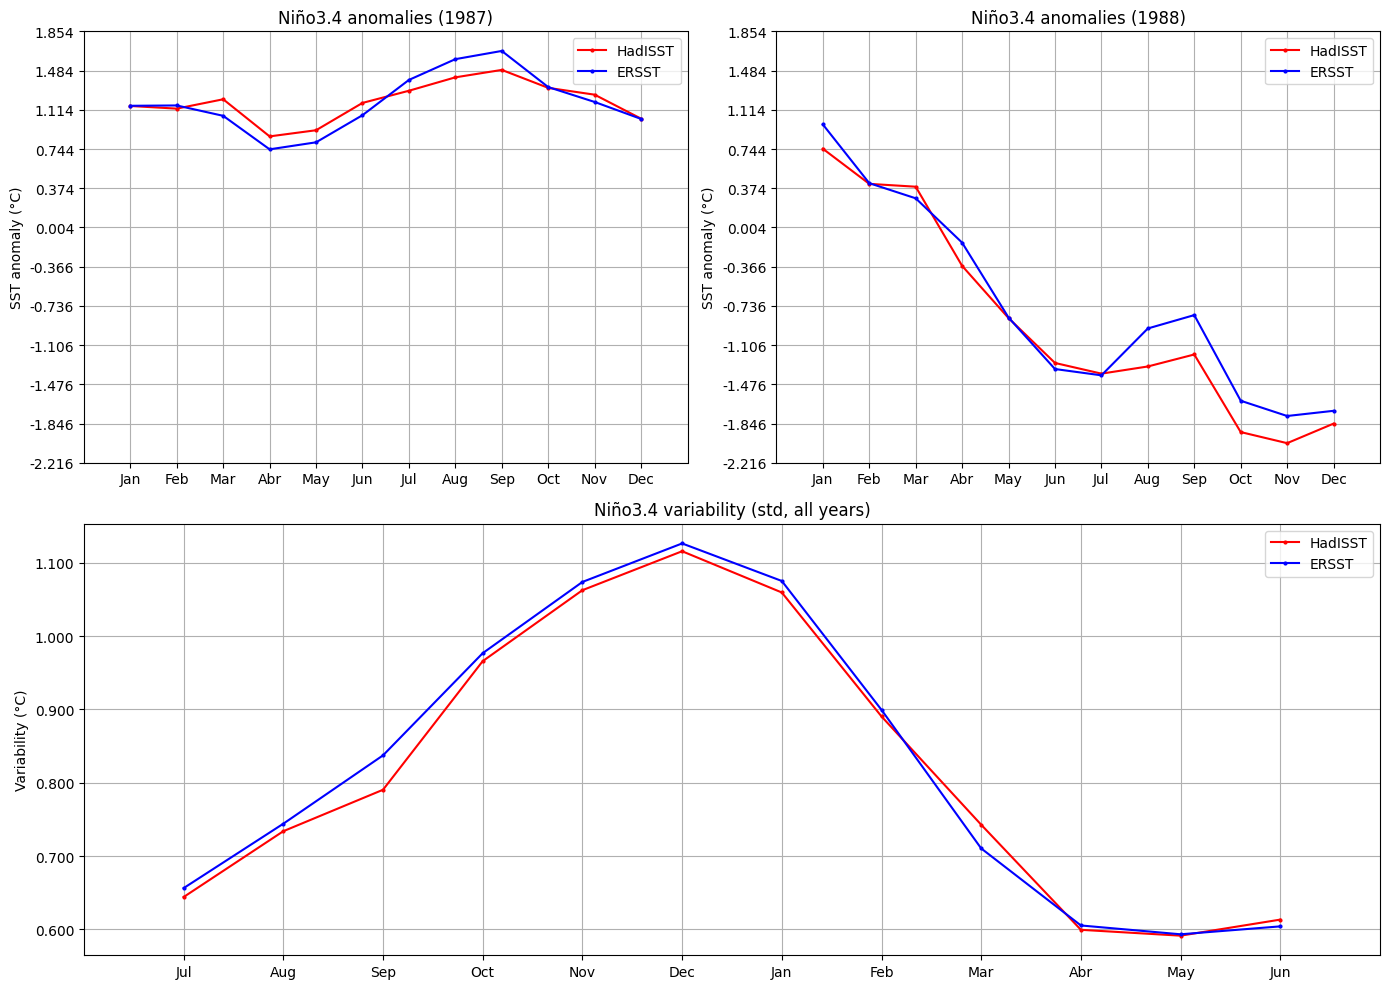

In [20]:
#POSSIBLE ENSO ENTRE 1987-1988

year1 = 1987
year2 = 1988


niño1_a, niño1_b = niño_monthly_series(year1,lat_min_enso, lat_max_enso, lon_min_enso, lon_max_enso)
niño2_a, niño2_b = niño_monthly_series(year2,lat_min_enso, lat_max_enso, lon_min_enso, lon_max_enso)

ymin = np.nanmin([niño1_a.min(), niño1_b.min(),niño2_a.min(), niño2_b.min()])
ymax = np.nanmax([niño1_a.max(), niño1_b.max(),niño2_a.max(), niño2_b.max()])

pad = 0.05 * (ymax - ymin)
ymin -= pad
ymax += pad

fig = plt.figure(figsize=(14, 10))

#2 columnas para arriba; abajo 1 eje centrado ocupando ambas columnas
gs = fig.add_gridspec(2, 2, height_ratios=[1, 1])

ax00 = fig.add_subplot(gs[0, 0])   # año1
ax01 = fig.add_subplot(gs[0, 1])   # año2
ax10 = fig.add_subplot(gs[1, :])   # variabilidad (ocupa 2 columnas -> centrado, mismo alto)

# Primer Año : anomalías mensuales ---
ax00.plot(meses, niño1_a, '-ro', markersize=2)
ax00.plot(meses, niño1_b, '-bo', markersize=2)
ax00.grid()
ax00.set_ylim(ymin, ymax)
ax00.set_yticks(np.linspace(ymin, ymax, 12))

ax00.set_ylabel('SST anomaly (°C)')
ax00.set_title(f'Niño3.4 anomalies ({year1})')

ax00.yaxis.set_major_formatter(ticker.FormatStrFormatter('%.3f'))
ax00.margins(x=0.0909)
ax00.legend(['HadISST','ERSST'])

#Segundo Año: anomalías mensuales ---
ax01.plot(meses, niño2_a, '-ro', markersize=2)
ax01.plot(meses, niño2_b, '-bo', markersize=2)
ax01.grid()
ax01.set_ylim(ymin, ymax)
ax01.set_yticks(np.linspace(ymin, ymax, 12))

ax01.set_ylabel('SST anomaly (°C)')
ax01.set_title(f'Niño3.4 anomalies ({year2})')
ax01.yaxis.set_major_formatter(ticker.FormatStrFormatter('%.3f'))
ax01.margins(x=0.0909)
ax01.legend(['HadISST','ERSST'])

# --- (3) Variabilidad mensual climatológica (una sola vez) ---
ax10.plot(meses_c, var_niño_a_c, '-ro', markersize=2)
ax10.plot(meses_c, var_niño_b_c, '-bo', markersize=2)
ax10.grid()
ax10.set_ylabel('Variability (°C)')
ax10.set_title('Niño3.4 variability (std, all years)')
ax10.yaxis.set_major_formatter(ticker.FormatStrFormatter('%.3f'))
ax10.margins(x=0.0909)
ax10.legend(['HadISST','ERSST'])

plt.tight_layout()
plt.show()

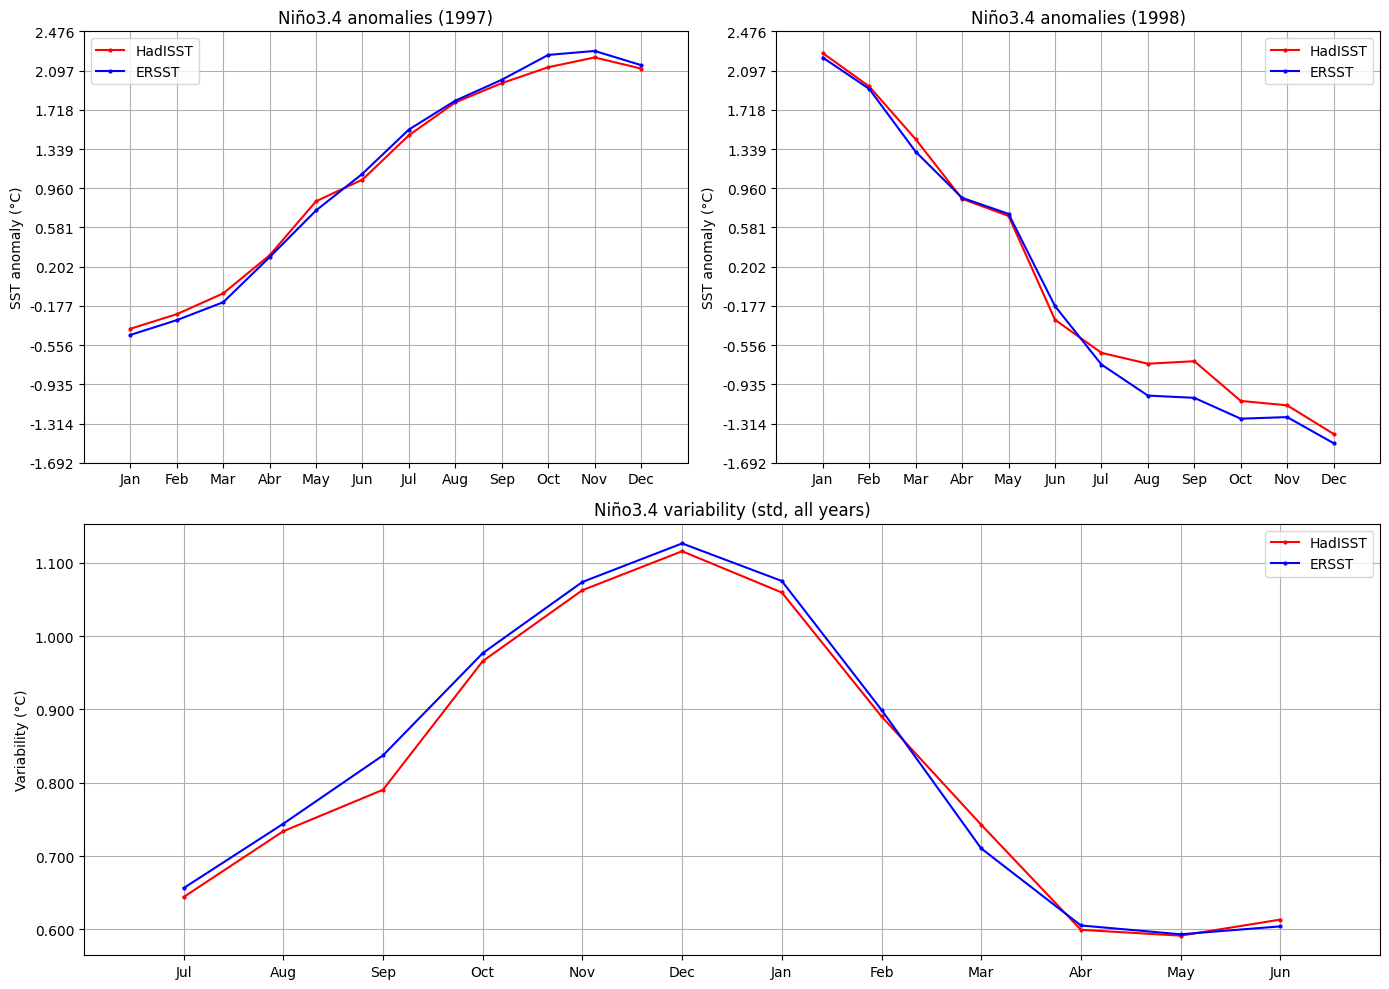

In [21]:
#POSSIBLE ENSO ENTRE 1997-1998

year1 = 1997
year2 = 1998


niño1_a, niño1_b = niño_monthly_series(year1,lat_min_enso, lat_max_enso, lon_min_enso, lon_max_enso)
niño2_a, niño2_b = niño_monthly_series(year2,lat_min_enso, lat_max_enso, lon_min_enso, lon_max_enso)

ymin = np.nanmin([niño1_a.min(), niño1_b.min(),niño2_a.min(), niño2_b.min()])
ymax = np.nanmax([niño1_a.max(), niño1_b.max(),niño2_a.max(), niño2_b.max()])

pad = 0.05 * (ymax - ymin)
ymin -= pad
ymax += pad

fig = plt.figure(figsize=(14, 10))

#2 columnas para arriba; abajo 1 eje centrado ocupando ambas columnas
gs = fig.add_gridspec(2, 2, height_ratios=[1, 1])

ax00 = fig.add_subplot(gs[0, 0])   # año1
ax01 = fig.add_subplot(gs[0, 1])   # año2
ax10 = fig.add_subplot(gs[1, :])   # variabilidad (ocupa 2 columnas -> centrado, mismo alto)

# Primer Año : anomalías mensuales ---
ax00.plot(meses, niño1_a, '-ro', markersize=2)
ax00.plot(meses, niño1_b, '-bo', markersize=2)
ax00.grid()
ax00.set_ylim(ymin, ymax)
ax00.set_yticks(np.linspace(ymin, ymax, 12))

ax00.set_ylabel('SST anomaly (°C)')
ax00.set_title(f'Niño3.4 anomalies ({year1})')

ax00.yaxis.set_major_formatter(ticker.FormatStrFormatter('%.3f'))
ax00.margins(x=0.0909)
ax00.legend(['HadISST','ERSST'])

#Segundo Año: anomalías mensuales ---
ax01.plot(meses, niño2_a, '-ro', markersize=2)
ax01.plot(meses, niño2_b, '-bo', markersize=2)
ax01.grid()
ax01.set_ylim(ymin, ymax)
ax01.set_yticks(np.linspace(ymin, ymax, 12))

ax01.set_ylabel('SST anomaly (°C)')
ax01.set_title(f'Niño3.4 anomalies ({year2})')
ax01.yaxis.set_major_formatter(ticker.FormatStrFormatter('%.3f'))
ax01.margins(x=0.0909)
ax01.legend(['HadISST','ERSST'])

# --- (3) Variabilidad mensual climatológica (una sola vez) ---
ax10.plot(meses_c, var_niño_a_c, '-ro', markersize=2)
ax10.plot(meses_c, var_niño_b_c, '-bo', markersize=2)
ax10.grid()
ax10.set_ylabel('Variability (°C)')
ax10.set_title('Niño3.4 variability (std, all years)')
ax10.yaxis.set_major_formatter(ticker.FormatStrFormatter('%.3f'))
ax10.margins(x=0.0909)
ax10.legend(['HadISST','ERSST'])

plt.tight_layout()
plt.show()

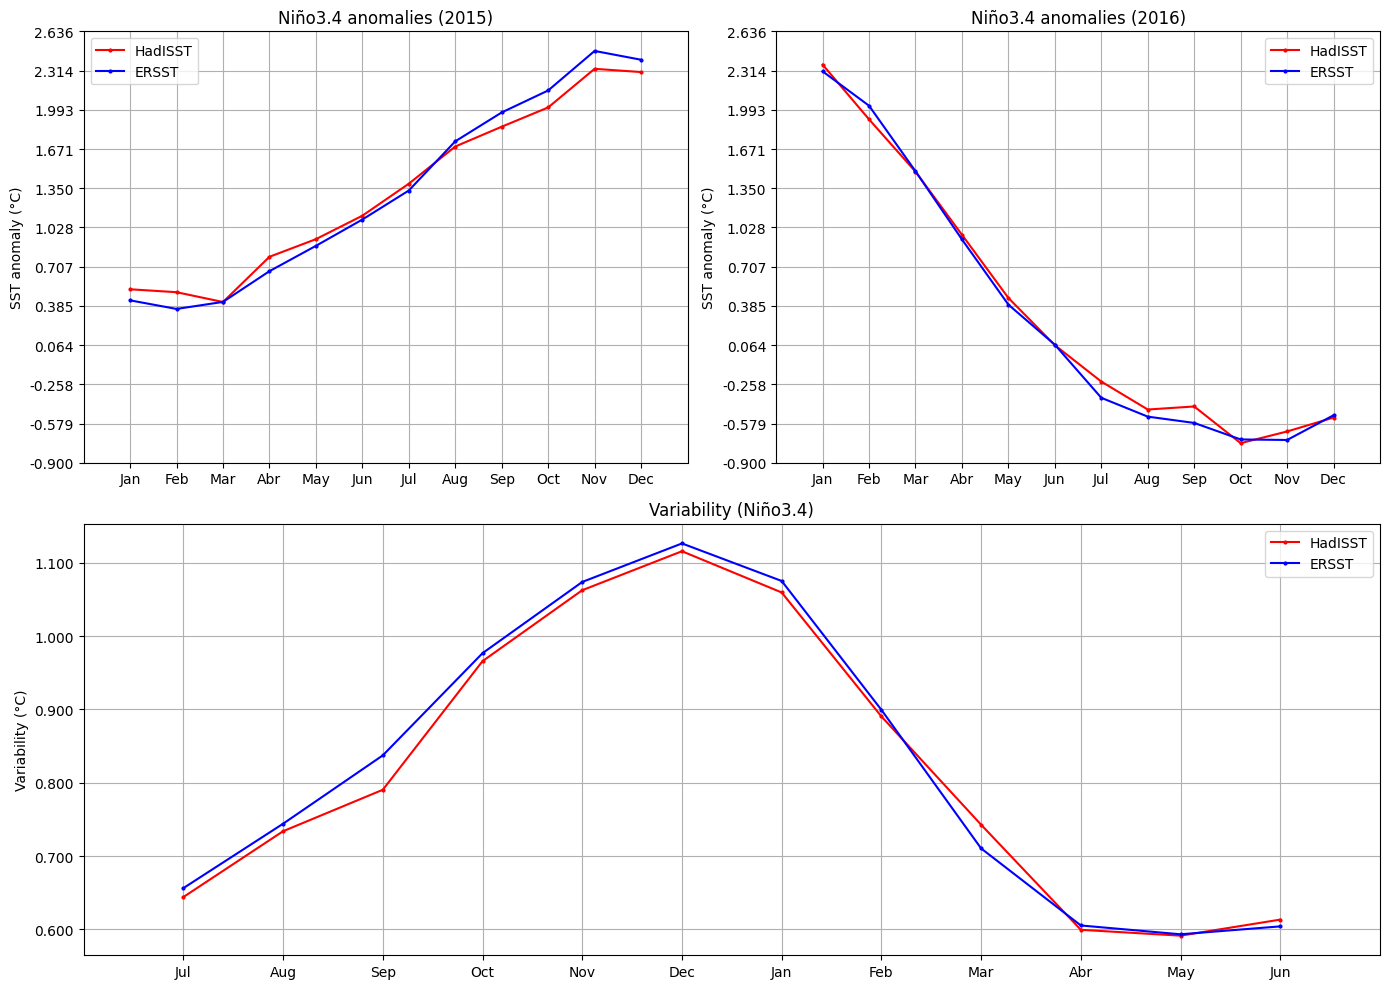

In [22]:
#POSSIBLE ENSO ENTRE 2015-2016
year1 = 2015
year2 = 2016  

niño1_a, niño1_b = niño_monthly_series(year1,lat_min_enso, lat_max_enso, lon_min_enso, lon_max_enso)
niño2_a, niño2_b = niño_monthly_series(year2,lat_min_enso, lat_max_enso, lon_min_enso, lon_max_enso)

ymin = np.nanmin([niño1_a.min(), niño1_b.min(),niño2_a.min(), niño2_b.min()])
ymax = np.nanmax([niño1_a.max(), niño1_b.max(),niño2_a.max(), niño2_b.max()])

pad = 0.05 * (ymax - ymin)
ymin -= pad
ymax += pad

fig = plt.figure(figsize=(14, 10))

#2 columnas para arriba; abajo 1 eje centrado ocupando ambas columnas
gs = fig.add_gridspec(2, 2, height_ratios=[1, 1])

ax00 = fig.add_subplot(gs[0, 0])   # año1
ax01 = fig.add_subplot(gs[0, 1])   # año2
ax10 = fig.add_subplot(gs[1, :])   # variabilidad (ocupa 2 columnas -> centrado, mismo alto)

# Primer Año : anomalías mensuales ---
ax00.plot(meses, niño1_a, '-ro', markersize=2)
ax00.plot(meses, niño1_b, '-bo', markersize=2)
ax00.grid()
ax00.set_ylim(ymin, ymax)
ax00.set_yticks(np.linspace(ymin, ymax, 12))

ax00.set_ylabel('SST anomaly (°C)')
ax00.set_title(f'Niño3.4 anomalies ({year1})')

ax00.yaxis.set_major_formatter(ticker.FormatStrFormatter('%.3f'))
ax00.margins(x=0.0909)
ax00.legend(['HadISST','ERSST'])

#Segundo Año: anomalías mensuales ---
ax01.plot(meses, niño2_a, '-ro', markersize=2)
ax01.plot(meses, niño2_b, '-bo', markersize=2)
ax01.grid()
ax01.set_ylim(ymin, ymax)
ax01.set_yticks(np.linspace(ymin, ymax, 12))

ax01.set_ylabel('SST anomaly (°C)')
ax01.set_title(f'Niño3.4 anomalies ({year2})')
ax01.yaxis.set_major_formatter(ticker.FormatStrFormatter('%.3f'))
ax01.margins(x=0.0909)
ax01.legend(['HadISST','ERSST'])

# --- (3) Variabilidad mensual climatológica (una sola vez) ---
ax10.plot(meses_c, var_niño_a_c, '-ro', markersize=2)
ax10.plot(meses_c, var_niño_b_c, '-bo', markersize=2)
ax10.grid()
ax10.set_ylabel('Variability (°C)')
ax10.set_title('Variability (Niño3.4)')
ax10.yaxis.set_major_formatter(ticker.FormatStrFormatter('%.3f'))
ax10.margins(x=0.0909)
ax10.legend(['HadISST','ERSST'])

plt.tight_layout()
plt.show()

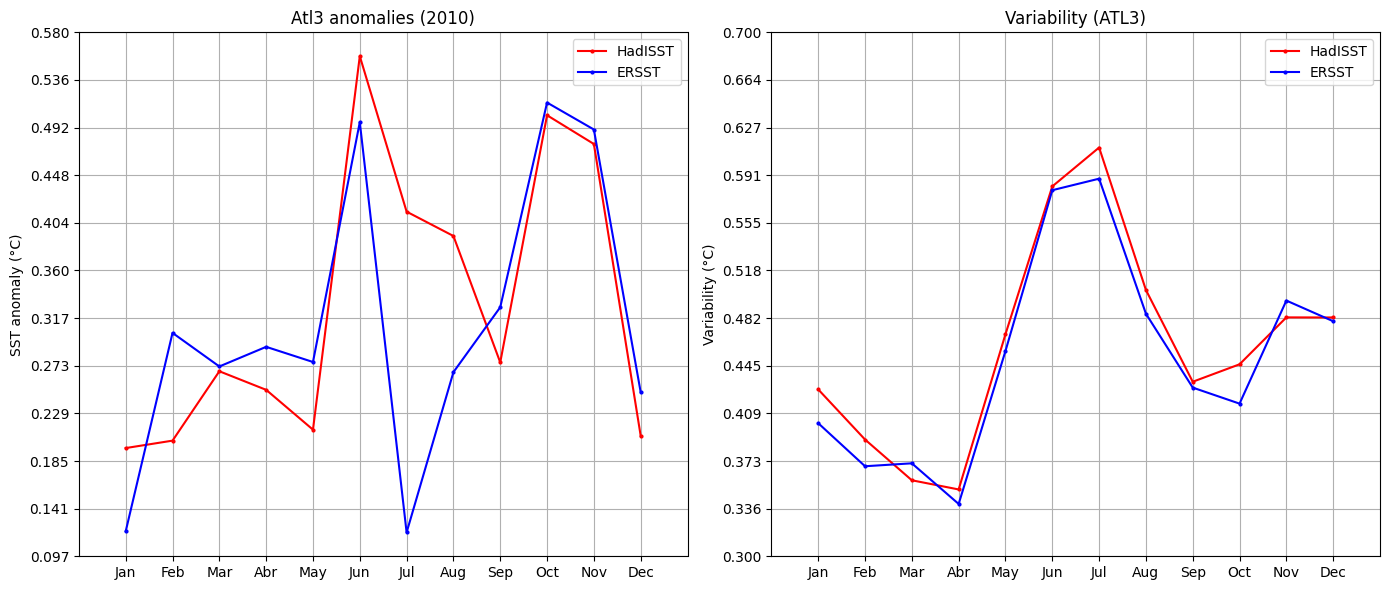

In [23]:
#POSSIBLE Atlantic Niño en 2010
year0 = 2010
niño_atl_a, niño_atl_b = niño_monthly_series(year0,lat_min_atl3, lat_max_atl3, lon_min_atl3, lon_max_atl3)
ymin = np.nanmin([niño_atl_a.min(),niño_atl_b.min()])
ymax = np.nanmax([niño_atl_a.max(),niño_atl_b.max()])

pad = 0.05 * (ymax - ymin)
ymin -= pad
ymax += pad
fig, ax = plt.subplots(1, 2, figsize=(14, 6))

ax[0].plot(meses, niño_atl_a,'-ro', markersize=2)
ax[0].plot(meses, niño_atl_b,'-bo', markersize=2)
ax[0].grid() # Agrega un fondo cuadriculado al gráfico
ax[0].set_ylabel('SST anomaly (°C)') # Renombra el eje y como "Variability (°C)"
ax[0].set_title(f'Atl3 anomalies ({year0})')
ax[0].set_ylim(ymin, ymax)
ax[0].set_yticks(np.linspace(ymin, ymax, 12))
ax[0].yaxis.set_major_formatter(ticker.FormatStrFormatter('%.3f')) # Formatea el eje y para mostrar solo 3 decimales
ax[0].margins(x=0.0909)
ax[0].legend(['HadISST','ERSST'])


ax[1].plot(meses, variacion_mensual_ATL3_a,'-ro', markersize=2)
ax[1].plot(meses, variacion_mensual_ATL3_b,'-bo', markersize=2)
ax[1].grid() # Agrega un fondo cuadriculado al gráfico
ax[1].set_ylabel('Variability (°C)') # Renombra el eje y como "Variability (°C)"
ax[1].set_title('Variability (ATL3)') 
ax[1].set_yticks(np.linspace(0.3, 0.7, 12)) # Establece 9 divisiones en el eje y
ax[1].yaxis.set_major_formatter(ticker.FormatStrFormatter('%.3f')) # Formatea el eje y para mostrar solo 3 decimales
ax[1].margins(x=0.0909)
ax[1].legend(['HadISST','ERSST'])

plt.tight_layout()
plt.show()

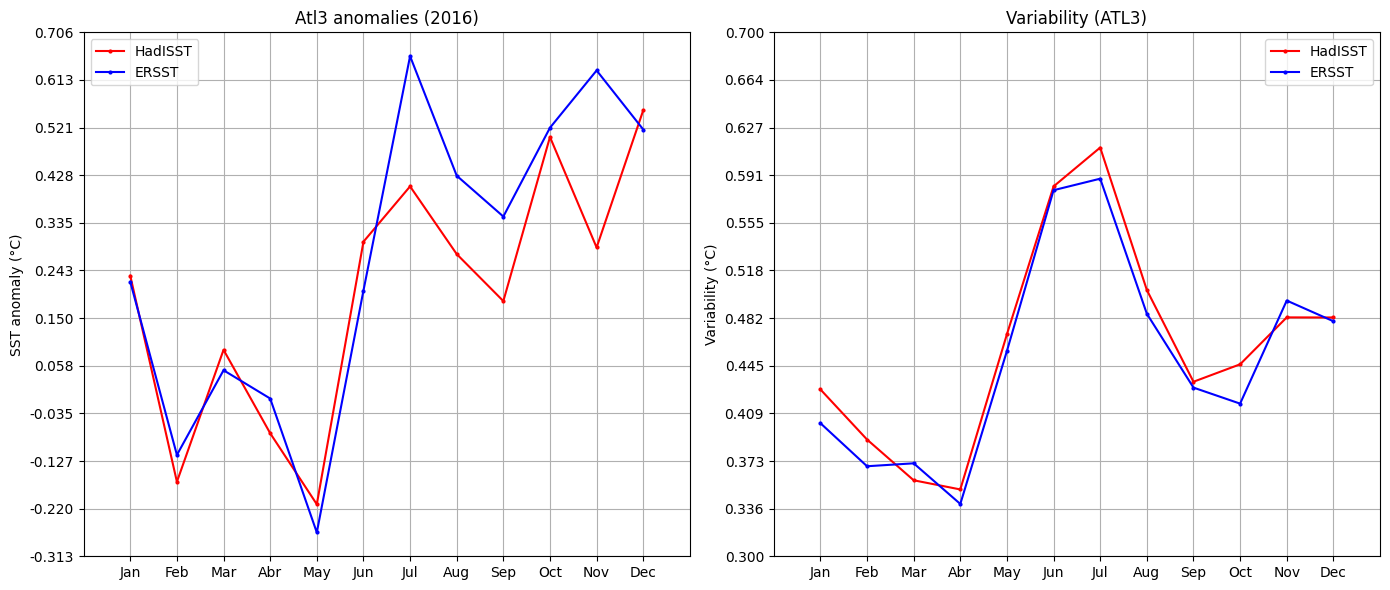

In [24]:
#POSSIBLE Atlantic Niño en 2018
year0 = 2016
niño_atl_a, niño_atl_b = niño_monthly_series(year0,lat_min_atl3, lat_max_atl3, lon_min_atl3, lon_max_atl3)
ymin = np.nanmin([niño_atl_a.min(),niño_atl_b.min()])
ymax = np.nanmax([niño_atl_a.max(),niño_atl_b.max()])

pad = 0.05 * (ymax - ymin)
ymin -= pad
ymax += pad
fig, ax = plt.subplots(1, 2, figsize=(14, 6))

ax[0].plot(meses, niño_atl_a,'-ro', markersize=2)
ax[0].plot(meses, niño_atl_b,'-bo', markersize=2)
ax[0].grid() # Agrega un fondo cuadriculado al gráfico
ax[0].set_ylabel('SST anomaly (°C)') # Renombra el eje y como "Variability (°C)"
ax[0].set_title(f'Atl3 anomalies ({year0})')
ax[0].set_ylim(ymin, ymax)
ax[0].set_yticks(np.linspace(ymin, ymax, 12))
ax[0].yaxis.set_major_formatter(ticker.FormatStrFormatter('%.3f')) # Formatea el eje y para mostrar solo 3 decimales
ax[0].margins(x=0.0909)
ax[0].legend(['HadISST','ERSST'])


ax[1].plot(meses, variacion_mensual_ATL3_a,'-ro', markersize=2)
ax[1].plot(meses, variacion_mensual_ATL3_b,'-bo', markersize=2)
ax[1].grid() # Agrega un fondo cuadriculado al gráfico
ax[1].set_ylabel('Variability (°C)') # Renombra el eje y como "Variability (°C)"
ax[1].set_title('Variability (ATL3)') 
ax[1].set_yticks(np.linspace(0.3, 0.7, 12)) # Establece 9 divisiones en el eje y
ax[1].yaxis.set_major_formatter(ticker.FormatStrFormatter('%.3f')) # Formatea el eje y para mostrar solo 3 decimales
ax[1].margins(x=0.0909)
ax[1].legend(['HadISST','ERSST'])

plt.tight_layout()
plt.show()

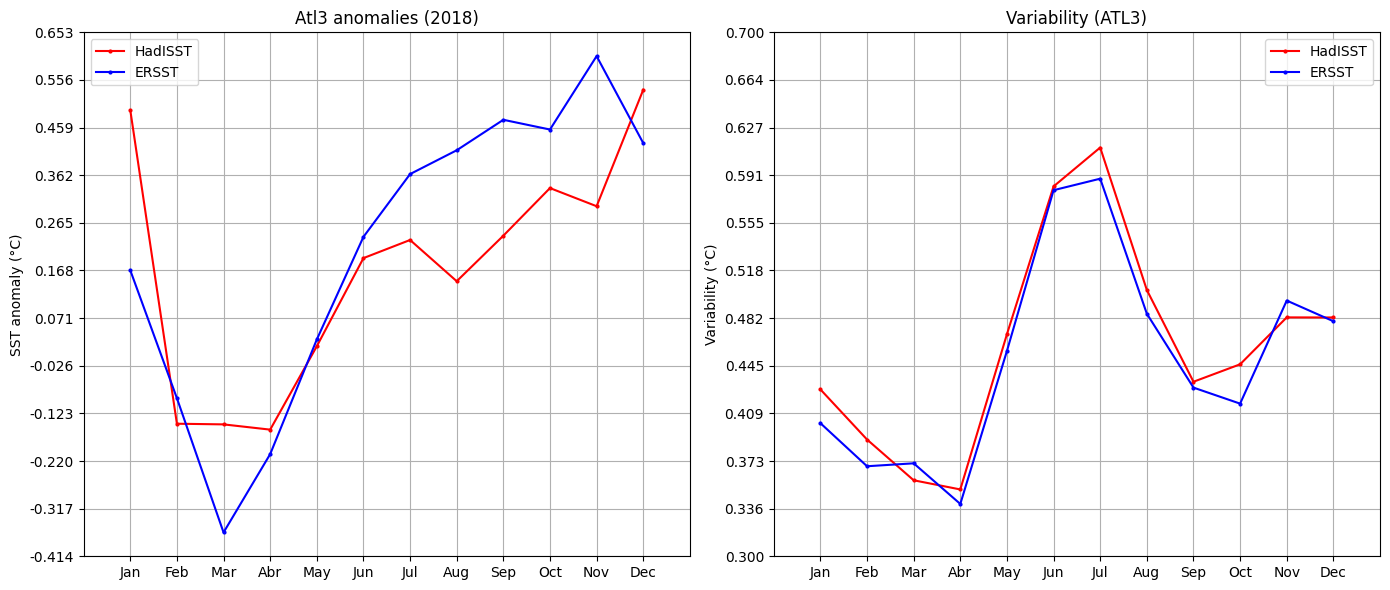

In [25]:
#POSSIBLE Atlantic Niño en 2010
year0 = 2018
niño_atl_a, niño_atl_b = niño_monthly_series(year0,lat_min_atl3, lat_max_atl3, lon_min_atl3, lon_max_atl3)
ymin = np.nanmin([niño_atl_a.min(),niño_atl_b.min()])
ymax = np.nanmax([niño_atl_a.max(),niño_atl_b.max()])

pad = 0.05 * (ymax - ymin)
ymin -= pad
ymax += pad
fig, ax = plt.subplots(1, 2, figsize=(14, 6))

ax[0].plot(meses, niño_atl_a,'-ro', markersize=2)
ax[0].plot(meses, niño_atl_b,'-bo', markersize=2)
ax[0].grid() # Agrega un fondo cuadriculado al gráfico
ax[0].set_ylabel('SST anomaly (°C)') # Renombra el eje y como "Variability (°C)"
ax[0].set_title(f'Atl3 anomalies ({year0})')
ax[0].set_ylim(ymin, ymax)
ax[0].set_yticks(np.linspace(ymin, ymax, 12))
ax[0].yaxis.set_major_formatter(ticker.FormatStrFormatter('%.3f')) # Formatea el eje y para mostrar solo 3 decimales
ax[0].margins(x=0.0909)
ax[0].legend(['HadISST','ERSST'])


ax[1].plot(meses, variacion_mensual_ATL3_a,'-ro', markersize=2)
ax[1].plot(meses, variacion_mensual_ATL3_b,'-bo', markersize=2)
ax[1].grid() # Agrega un fondo cuadriculado al gráfico
ax[1].set_ylabel('Variability (°C)') # Renombra el eje y como "Variability (°C)"
ax[1].set_title('Variability (ATL3)') 
ax[1].set_yticks(np.linspace(0.3, 0.7, 12)) # Establece 9 divisiones en el eje y
ax[1].yaxis.set_major_formatter(ticker.FormatStrFormatter('%.3f')) # Formatea el eje y para mostrar solo 3 decimales
ax[1].margins(x=0.0909)
ax[1].legend(['HadISST','ERSST'])

plt.tight_layout()
plt.show()

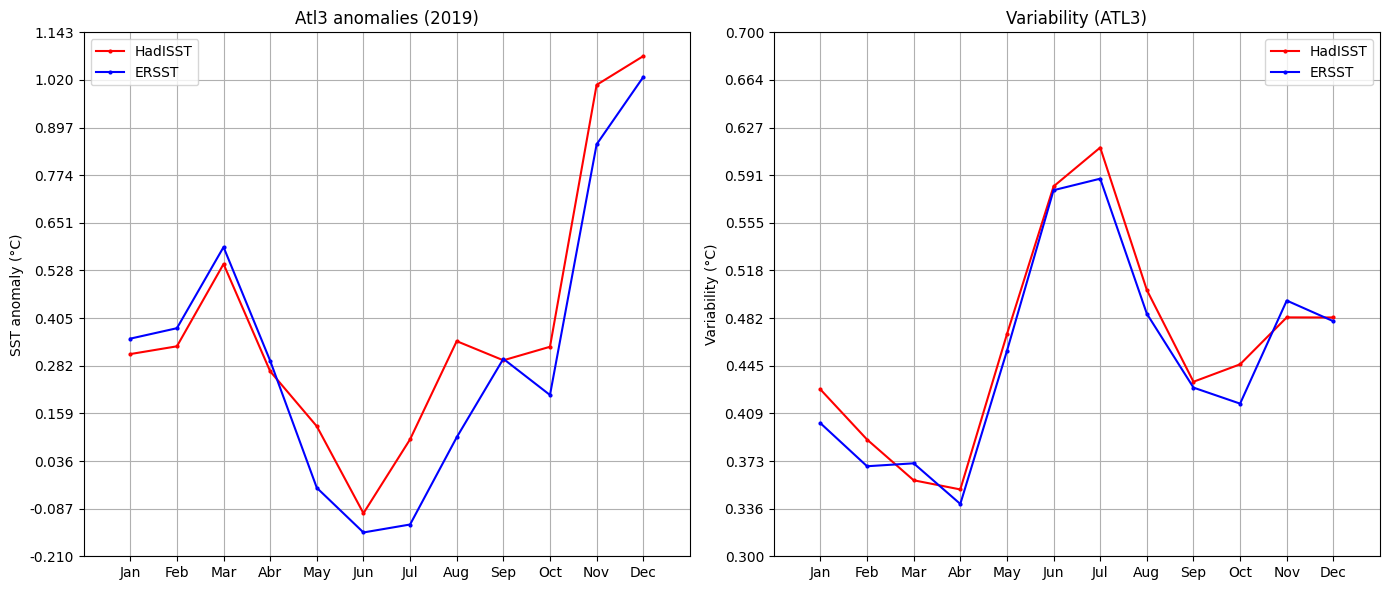

In [26]:
#POSSIBLE Atlantic Niño en 2019
year0 = 2019
niño_atl_a, niño_atl_b = niño_monthly_series(year0,lat_min_atl3, lat_max_atl3, lon_min_atl3, lon_max_atl3)
ymin = np.nanmin([niño_atl_a.min(),niño_atl_b.min()])
ymax = np.nanmax([niño_atl_a.max(),niño_atl_b.max()])

pad = 0.05 * (ymax - ymin)
ymin -= pad
ymax += pad
fig, ax = plt.subplots(1, 2, figsize=(14, 6))

ax[0].plot(meses, niño_atl_a,'-ro', markersize=2)
ax[0].plot(meses, niño_atl_b,'-bo', markersize=2)
ax[0].grid() # Agrega un fondo cuadriculado al gráfico
ax[0].set_ylabel('SST anomaly (°C)') # Renombra el eje y como "Variability (°C)"
ax[0].set_title(f'Atl3 anomalies ({year0})')
ax[0].set_ylim(ymin, ymax)
ax[0].set_yticks(np.linspace(ymin, ymax, 12))
ax[0].yaxis.set_major_formatter(ticker.FormatStrFormatter('%.3f')) # Formatea el eje y para mostrar solo 3 decimales
ax[0].margins(x=0.0909)
ax[0].legend(['HadISST','ERSST'])


ax[1].plot(meses, variacion_mensual_ATL3_a,'-ro', markersize=2)
ax[1].plot(meses, variacion_mensual_ATL3_b,'-bo', markersize=2)
ax[1].grid() # Agrega un fondo cuadriculado al gráfico
ax[1].set_ylabel('Variability (°C)') # Renombra el eje y como "Variability (°C)"
ax[1].set_title('Variability (ATL3)') 
ax[1].set_yticks(np.linspace(0.3, 0.7, 12)) # Establece 9 divisiones en el eje y
ax[1].yaxis.set_major_formatter(ticker.FormatStrFormatter('%.3f')) # Formatea el eje y para mostrar solo 3 decimales
ax[1].margins(x=0.0909)
ax[1].legend(['HadISST','ERSST'])

plt.tight_layout()
plt.show()

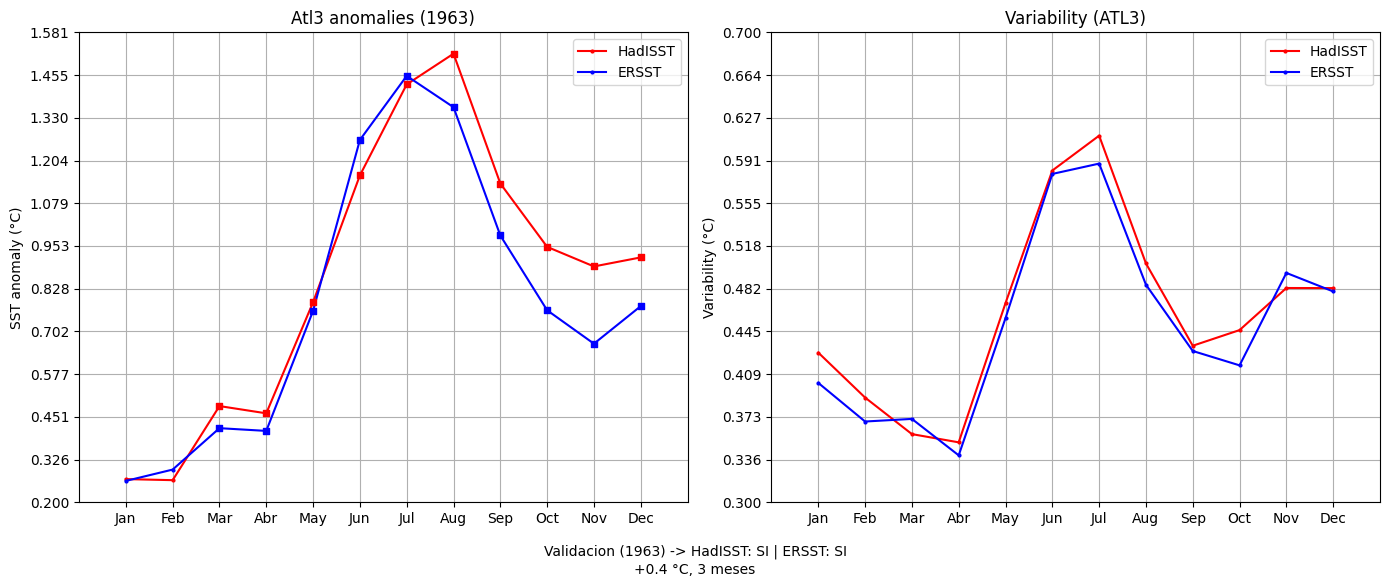

In [37]:
#POSSIBLE Atlantic Niño en 2020
def Detection_Plot_ATL3(year0, criterio=0.4, nmeses=3):
    niño_atl_a, niño_atl_b = niño_monthly_series(year0,lat_min_atl3, lat_max_atl3, lon_min_atl3, lon_max_atl3)

    def runs(mask, n):
        m = np.asarray(mask, dtype=bool)
        x = np.r_[False, m, False]
        d = np.diff(x.astype(int))
        starts = np.where(d == 1)[0]
        ends = np.where(d == -1)[0]
        valid = (ends - starts) >= n
        out = np.zeros_like(m, dtype=bool)
        for s, e, v in zip(starts, ends, valid):
            if v:
                out[s:e] = True
        return out

    mask_a = niño_atl_a >= criterio
    mask_b = niño_atl_b >= criterio
    valid_a = runs(mask_a, nmeses)
    valid_b = runs(mask_b, nmeses)

    ymin = np.nanmin([niño_atl_a.min(),niño_atl_b.min()])
    ymax = np.nanmax([niño_atl_a.max(),niño_atl_b.max()])
    pad = 0.05 * (ymax - ymin)
    ymin -= pad
    ymax += pad

    fig, ax = plt.subplots(1, 2, figsize=(14, 6))

    ax[0].plot(meses, niño_atl_a,'-ro', markersize=2)
    ax[0].plot(meses, niño_atl_b,'-bo', markersize=2)
    ax[0].grid()
    ax[0].set_ylabel('SST anomaly (°C)')
    ax[0].set_title(f'Atl3 anomalies ({year0})')
    ax[0].set_ylim(ymin, ymax)
    ax[0].set_yticks(np.linspace(ymin, ymax, 12))
    ax[0].yaxis.set_major_formatter(ticker.FormatStrFormatter('%.3f'))
    ax[0].margins(x=0.0909)
    ax[0].legend(['HadISST','ERSST'])

    if np.any(valid_a):
        ax[0].scatter(np.array(meses)[valid_a], np.array(niño_atl_a)[valid_a], s=18, marker='s', color='red', zorder=3)
    if np.any(valid_b):
        ax[0].scatter(np.array(meses)[valid_b], np.array(niño_atl_b)[valid_b], s=18, marker='s', color='blue', zorder=3)

    ax[1].plot(meses, variacion_mensual_ATL3_a,'-ro', markersize=2)
    ax[1].plot(meses, variacion_mensual_ATL3_b,'-bo', markersize=2)
    ax[1].grid()
    ax[1].set_ylabel('Variability (°C)')
    ax[1].set_title('Variability (ATL3)')
    ax[1].set_yticks(np.linspace(0.3, 0.7, 12))
    ax[1].yaxis.set_major_formatter(ticker.FormatStrFormatter('%.3f'))
    ax[1].margins(x=0.0909)
    ax[1].legend(['HadISST','ERSST'])

    plt.tight_layout(rect=[0, 0.09, 1, 1])
    fig.text(0.5, 0.03, f'+{criterio:.1f} °C, {nmeses} meses', ha='center', va='bottom', fontsize=10)

    txt_a = 'HadISST: SI' if np.any(valid_a) else 'HadISST: NO'
    txt_b = 'ERSST: SI' if np.any(valid_b) else 'ERSST: NO'
    fig.text(0.5, 0.06, f'Validacion ({year0}) -> {txt_a} | {txt_b}', ha='center', va='bottom', fontsize=10)

    plt.show()

Detection_Plot_ATL3(1963)

<div style="
background-color:#f7f7f7;
border-left:5px solid #444;
padding:14px;
border-radius:4px;
">
“Initial selection based on annual mean SST in the ATL3 region led to inconsistent candidates, dominated by the long-term warming signal and lacking a clear JJA peak. Therefore, a refined selection based on JJA anomalies was adopted.”

</div>

In [28]:
#NUEVOS TOP 5 PARA ATL3, vemos que buscar los años donde en esa zona las anomalias sean mas grandes no sirve de forma anual
#Vamos a fijarnos solo en los meses junio julio y agosto de cada año

Anoms_ATL3_JJA_a = []

for i in range(61):
    # JJA
    atl3_JJA = anoms_a[i, 5:8, 86:94, 160:180]  # (3, lat, lon)
    Anoms_ATL3_JJA_a.append(np.nanmean(atl3_JJA))

Anoms_ATL3_JJA_a = np.array(Anoms_ATL3_JJA_a)

Anoms_ATL3_JJA_b = []

for i in range(61):
    atl3_JJA = anoms_b[i, 5:8, 42:47, 170:180]
    Anoms_ATL3_JJA_b.append(np.nanmean(atl3_JJA))

Anoms_ATL3_JJA_b = np.array(Anoms_ATL3_JJA_b)

atl3 = top5(years, Anoms_ATL3_JJA_a,Anoms_ATL3_JJA_b, N) #recordamos years=(np.arange(1960, 2021, 1))


fmt = {"HadISST (°C)": "{:.2f}", "ERSST (°C)": "{:.2f}"}
header_style = [{"selector":"th","props":[("padding-top","2px"),("padding-bottom","2px"),
                                         ("vertical-align","bottom"),("text-align","center")]}]

s_atl3 = atl3.style.format(fmt).set_properties(**{"text-align":"center"}).set_table_styles(header_style)
s_nino = nino.style.format(fmt).set_properties(**{"text-align":"center"}).set_table_styles(header_style)

html = f"""
<div style="text-align:left; font-weight:bold; font-size:15px; margin-bottom:12px;">
Picos de SST media anual (1960–2020)
</div>

<div style="display:flex; justify-content:left; gap:80px;">
  <div>
    <div style="font-weight:bold; margin-bottom:6px;">Atlantic Niño (ATL3):</div>
    {s_atl3.to_html()}
  </div>
  <div>
    <div style="font-weight:bold; margin-bottom:6px;">Pacific Niño (Niño 3.4):</div>
    {s_nino.to_html()}
  </div>
</div>
"""

display(HTML(html))




<div style="
background-color:#f7f7f7;
border-left:5px solid #444;
padding:14px;
border-radius:4px;
">

<strong>Reformulación de la selección de años para el índice ATL3</strong>

En esta sección se ha reformulado la selección de los años representativos del índice <strong>ATL3</strong>, introduciendo dos cambios metodológicos esenciales:

<ul>
  <li>
    <strong>Uso de anomalías en lugar de SST absoluta.</strong><br>
    Se emplean anomalías para evitar que la identificación de los eventos esté condicionada por el calentamiento de fondo.  
    En el caso del <strong>ENSO</strong>, los meses característicos del fenómeno presentan picos de anomalía suficientemente intensos como para modificar de forma significativa la media anual, de modo que analizar el conjunto del año o centrarse únicamente en los meses del evento conduce a resultados similares.  
    Por el contrario, en el <strong>Atlantic Niño</strong> las anomalías son más débiles y están confinadas a un periodo estacional concreto, por lo que los meses de máximo calentamiento no influyen de forma determinante en la media anual. En consecuencia, años con SST media anual elevada no necesariamente corresponden a eventos ATL3, sino que pueden reflejar anomalías ocurridas fuera de la estación del fenómeno.
  </li>

  <li>
    <strong>Selección estacional en lugar de anual.</strong><br>
    En lugar de utilizar la media anual en la región ATL3, se calcula la media de las anomalías exclusivamente durante los meses característicos del fenómeno (<strong>junio–julio–agosto, JJA</strong>) y se seleccionan los <strong>cinco años con mayor valor medio</strong>.  
    Este enfoque permite identificar eventos en los que el calentamiento está realmente asociado al Atlantic Niño y no a anomalías fuera de la estación del fenómeno.  
    Para el <strong>Pacific Niño (Niño 3.4)</strong>, la selección anual resulta menos problemática, ya que los meses del evento dominan la señal anual y determinan los años más cálidos en la región.
  </li>
</ul>

</div
